## Hypothesis II - Proposed Modeling Approach IV

##### Input: Raw Images

##### Downstream Model: 3D CNN

##### Validation: 75/25 split (leave-one-replicate-out)


In [1]:
import operator
import os
import datetime
import copy
import gc

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

import tensorflow as tf
from tensorflow.keras import layers
from tensorboard.plugins.hparams import api as hparams_api
import keras_tuner as kt

import imgaug

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import shap

import cv2

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


#### Remove noData Pixels Function


In [2]:
def filterNoData2(band):
    band_filtered = band

    operatorLookup = {">": operator.gt, "<": operator.lt}

    threshold = 100
    comparison = ">"

    # check if noData value is extremely large or small
    if len(band_filtered[band_filtered > 100]) > 0:
        threshold = 100
        comparison = ">"

    elif len(band_filtered[band_filtered < -100]) > 0:
        threshold = -100
        comparison = "<"

    op = operatorLookup.get(comparison)

    # find the indices of the non-noData pixels
    nonNoDataIndices = np.where(~op(band, threshold))

    # determine the minimum and maximum row and column indices of the non-noData pixels
    rowIndices = (min(nonNoDataIndices[0]), max(nonNoDataIndices[0]))
    colIndices = (min(nonNoDataIndices[1]), max(nonNoDataIndices[1]))

    # extract a subarray that only includes the non-noData pixels
    croppedImg = band[
        rowIndices[0] : rowIndices[1] + 1, colIndices[0] : colIndices[1] + 1
    ]

    band_filtered = croppedImg

    # iterate through rows
    offset = 0
    for row in range(0, band_filtered.shape[0]):
        # delete row if more than 1/3 of it contains noData values
        if len(np.argwhere(op(band_filtered[row - offset], threshold))) > 3:
            # if len(np.argwhere(op(band_filtered[row - offset], threshold))) > 0.15 * len(band_filtered[row - offset]):
            # print(f"Deleting row {row} with offset {offset}")
            band_filtered = np.delete(band_filtered, row - offset, 0)
            offset += 1

        row += 1

    # iterate through cols
    offset = 0
    for col in range(0, band_filtered.shape[1]):
        if len(np.argwhere(op(band_filtered[:, col - offset], threshold))) > 0:
            # print(f"Deleting column {col} with offset {offset}")
            band_filtered = np.delete(band_filtered, col - offset, 1)
            offset += 1

        col += 1

    return band_filtered

#### Load Yield Data


In [3]:
df_2022 = pd.read_csv("../../../../Datasets/Agronomic/2022/Dataset_2022.csv")
df_2022 = df_2022.sort_values(by="Plot_Number")

# remove missing yield
df_2022 = df_2022[df_2022["Yield"].notna()].reset_index(drop=True)

# get plot Numbers
df_2022["Plot_Number"] = df_2022["Plot_Number"].astype(str)
plotNumbers_2021 = list(df_2022["Plot_Number"].unique())

# keep only necessary attributes
df_2022 = df_2022.iloc[:, [0, 1, 2, 5, 6, 7]]
df_2022

Plot_Number Rice_Cultivar  Experiment_Name  Nitrogen_Rate  Replicate  \
0         31760      RT7521FP  Hybrid_RT7521FP            130          1   
1         31761      RT7521FP  Hybrid_RT7521FP            130          1   
2         31762      RT7521FP  Hybrid_RT7521FP            130          1   
3         31763      RT7521FP  Hybrid_RT7521FP            130          1   
4         31764      RT7521FP  Hybrid_RT7521FP            130          1   
..          ...           ...              ...            ...        ...   
147       31935        IAC600            Tiara            200          2   
148       31936         Tiara            Tiara            200          3   
149       31937        IAC600            Tiara            200          3   
150       31938        Sierra            Tiara            200          3   
151       31939      Scarlett            Tiara            200          3   

         Yield  
0    13.701755  
1    13.701755  
2    14.915789  
3    12.834534  
4    13.354943  
..         ...  
147   4.112456  
148   4.482405  
149   3.667944  
150   6.088385  
151  10.083261  

[152 rows x 6 columns]

**Split Plots into Train/Test** <br>
The split is done in a leave-one-replicate-out fashion. For each group of plots, one replicate is left out for validaiton while the rest is trained on.


In [4]:
seedCounter = 100
trainPlots = []
testPlots = []

for e in df_2022["Experiment_Name"].unique():
    for c in df_2022[df_2022["Experiment_Name"] == e]["Rice_Cultivar"].unique():
        for n in df_2022[
            (df_2022["Experiment_Name"] == e) & (df_2022["Rice_Cultivar"] == c)
        ]["Nitrogen_Rate"].unique():
            replicates = df_2022[
                (df_2022["Experiment_Name"] == e)
                & (df_2022["Rice_Cultivar"] == c)
                & (df_2022["Nitrogen_Rate"] == n)
            ]["Replicate"].unique()

            # set seed for each random pick for reproducibility
            np.random.seed(seedCounter)
            picked = np.random.choice(replicates)
            seedCounter += 1

            train = df_2022[
                (df_2022["Experiment_Name"] == e)
                & (df_2022["Rice_Cultivar"] == c)
                & (df_2022["Nitrogen_Rate"] == n)
                & (df_2022["Replicate"] != picked)
            ]["Plot_Number"].values

            test = df_2022[
                (df_2022["Experiment_Name"] == e)
                & (df_2022["Rice_Cultivar"] == c)
                & (df_2022["Nitrogen_Rate"] == n)
                & (df_2022["Replicate"] == picked)
            ]["Plot_Number"].values

            print(
                f"Experiment: {e}, Cultivar: {c}, Nitrogen: {n} \n"
                f"Train plots: {train}\n"
                f"Test plots: {test}\n"
                f"---------------------------------------------------------------"
            )

            trainPlots.extend(train)
            testPlots.extend(test)

del e, c, n, replicates, seedCounter, train, test

Experiment: Hybrid_RT7521FP, Cultivar: RT7521FP, Nitrogen: 130 
Train plots: ['31770' '31771' '31772' '31773' '31774' '31775' '31776' '31777' '31778'
 '31779' '31780' '31781' '31782' '31783' '31784' '31785' '31786' '31787'
 '31788' '31789']
Test plots: ['31760' '31761' '31762' '31763' '31764' '31765' '31766' '31767' '31768'
 '31769']
---------------------------------------------------------------
Experiment: Inbred_Jeff + NIL, Cultivar: NIL 43, Nitrogen: 130 
Train plots: ['31790' '31793' '31795' '31797' '31799' '31810' '31812' '31816' '31818'
 '31819']
Test plots: ['31802' '31805' '31807' '31808' '31809']
---------------------------------------------------------------
Experiment: Inbred_Jeff + NIL, Cultivar: Jefferson, Nitrogen: 130 
Train plots: ['31800' '31801' '31803' '31804' '31806' '31811' '31813' '31814' '31815'
 '31817']
Test plots: ['31791' '31792' '31794' '31796' '31798']
---------------------------------------------------------------
Experiment: Mini_Core, Cultivar: EMBRAPA 

#### Load and Preprocess Images


In [9]:
imgsPath = "../../../../Datasets/Images"
LATE_BOOT_DATES = ["06-09-2022", "06-17-2022", "06-25-2022", "07-19-2022"]
RESIZE_DIM = (40, 18)

# index 0: train, index 1: test
imgs = [[], []]
imgIndex = 0
dateIndex = 0

for imgSet in os.listdir(imgsPath):
    if imgSet == "Test":
        for date in os.listdir(os.path.join(imgsPath, imgSet)):
            # filter dates
            if date in LATE_BOOT_DATES:
                for plotNumber in sorted(
                    os.listdir(os.path.join(imgsPath, imgSet, date))
                ):
                    # filter missing yield plots
                    if plotNumber in plotNumbers_2021:
                        imgDir = os.path.join(imgsPath, imgSet, date, plotNumber)

                        # read imgs -> filter noData pixels -> resize to predefined dimension
                        r = cv2.resize(
                            filterNoData2(
                                cv2.imread(os.path.join(imgDir, "red.tiff"), -1)
                            ),
                            RESIZE_DIM,
                            cv2.INTER_AREA,
                        )
                        g = cv2.resize(
                            filterNoData2(
                                cv2.imread(os.path.join(imgDir, "green.tiff"), -1)
                            ),
                            RESIZE_DIM,
                            cv2.INTER_AREA,
                        )
                        b = cv2.resize(
                            filterNoData2(
                                cv2.imread(os.path.join(imgDir, "blue.tiff"), -1)
                            ),
                            RESIZE_DIM,
                            cv2.INTER_AREA,
                        )
                        nir = cv2.resize(
                            filterNoData2(
                                cv2.imread(os.path.join(imgDir, "nir.tiff"), -1)
                            ),
                            RESIZE_DIM,
                            cv2.INTER_AREA,
                        )
                        r_e = cv2.resize(
                            filterNoData2(
                                cv2.imread(os.path.join(imgDir, "red_edge.tiff"), -1)
                            ),
                            RESIZE_DIM,
                            cv2.INTER_AREA,
                        )

                        if plotNumber in trainPlots:
                            imgIndex = 0
                        elif plotNumber in testPlots:
                            imgIndex = 1
                        else:
                            raise Exception(
                                f"Plot number {plotNumber} is not in either training or validaiton lists"
                            )

                        # Stack the 5 channels
                        imgs[imgIndex].append(np.stack((r, g, b, nir, r_e), axis=2))

                dateIndex += 1

xTrain = np.stack(imgs[0], axis=0)
xTest = np.stack(imgs[1], axis=0)

del (
    r,
    g,
    b,
    nir,
    r_e,
    imgSet,
    date,
    plotNumber,
    imgDir,
    imgsPath,
    imgs,
    imgIndex,
    dateIndex,
)

In [6]:
dfTrain = df_2022[df_2022["Plot_Number"].isin(trainPlots)].reset_index(drop=True)
dfTrain

Plot_Number Rice_Cultivar  Experiment_Name  Nitrogen_Rate  Replicate  \
0         31770      RT7521FP  Hybrid_RT7521FP            130          2   
1         31771      RT7521FP  Hybrid_RT7521FP            130          2   
2         31772      RT7521FP  Hybrid_RT7521FP            130          2   
3         31773      RT7521FP  Hybrid_RT7521FP            130          2   
4         31774      RT7521FP  Hybrid_RT7521FP            130          2   
..          ...           ...              ...            ...        ...   
98        31931         Tiara            Tiara            200          1   
99        31932      Scarlett            Tiara            200          2   
100       31933         Tiara            Tiara            200          2   
101       31934        Sierra            Tiara            200          2   
102       31937        IAC600            Tiara            200          3   

         Yield  
0    13.875162  
1    13.354943  
2    13.701755  
3    14.222165  
4    14.222165  
..         ...  
98    6.033897  
99   10.484756  
100   5.695494  
101   6.441127  
102   3.667944  

[103 rows x 6 columns]

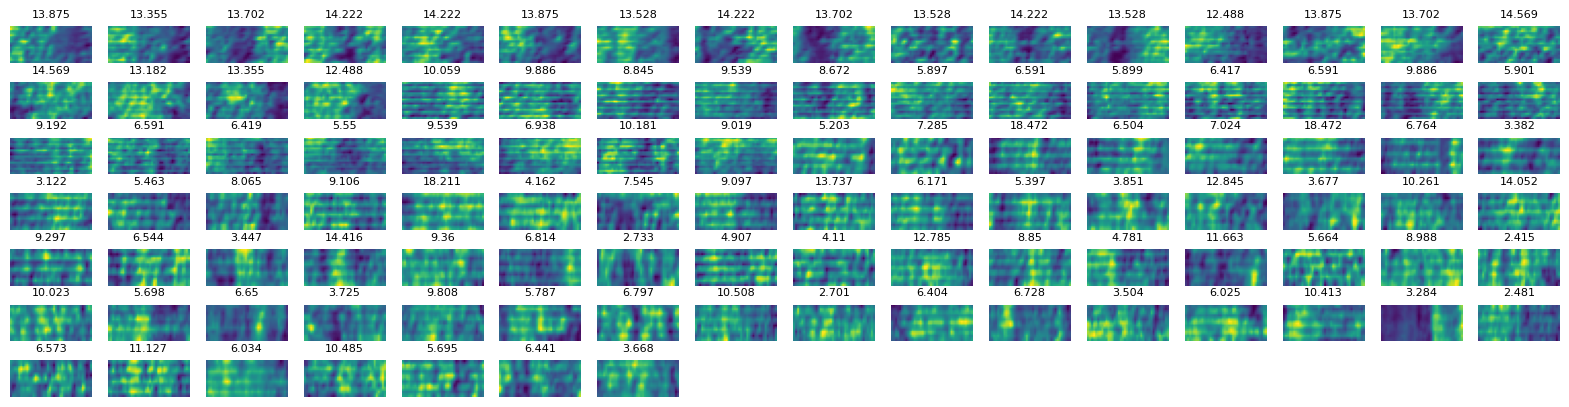

In [7]:
# Plot images for visual confirmation
plt.figure(figsize=(20, 10))
i = 1
j = 0

for k in np.arange(len(trainPlots) * j, len(trainPlots) + (len(trainPlots) * j), 1):
    plt.subplot(14, 16, i)
    plt.imshow(xTrain[k, :, :, 3])
    plt.axis("off")
    plt.title(
        round(dfTrain.iloc[i - 1]["Yield"], 3),
        size=8,
    )
    i += 1

del i, k, j

#### 3D CNN Preprocessing


In [7]:
# Reorder images such that the same plot across timepoints is consecutive (to be able to reshape later)
xTrainTimepoints = np.empty(shape=xTrain.shape)

counter = 0
for plot in np.arange(0, len(trainPlots), 1):
    for timepoint in np.arange(plot, len(xTrain), len(trainPlots)):
        xTrainTimepoints[counter] = xTrain[timepoint, :, :, :]
        counter += 1

# add time dimension
N_TIMEPOINTS = 4
xTrainTimepoints = xTrainTimepoints.reshape(
    (len(trainPlots), N_TIMEPOINTS) + xTrainTimepoints.shape[1:]
)

del counter, plot, timepoint

#### Visually Validate Reordering


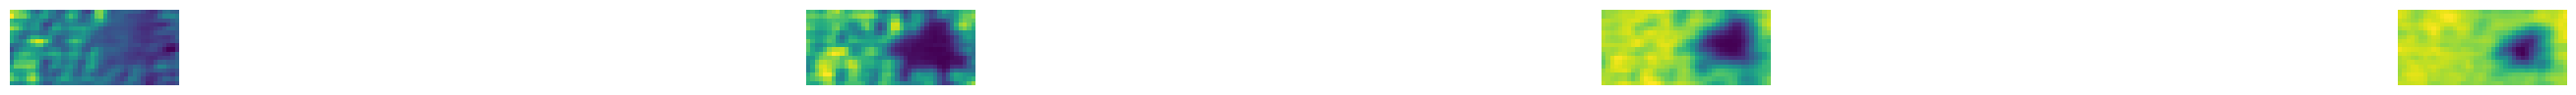

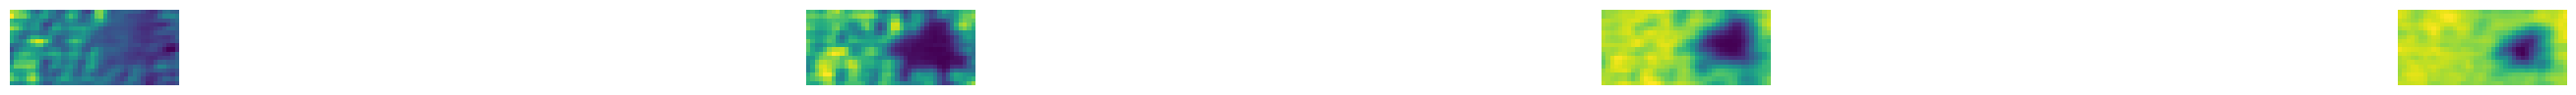

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(40, 1))
plot = 0

counter = 0
for i in np.arange(plot, len(xTrain), len(trainPlots)):
    axes[counter].imshow(xTrain[i, :, :, 3])
    axes[counter].set_axis_off()
    counter += 1

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(40, 1))

counter = 0
for i in np.arange(0, xTrainTimepoints.shape[1], 1):
    axes[counter].imshow(xTrainTimepoints[plot, i, :, :, 3])
    axes[counter].set_axis_off()
    counter += 1

del fig, axes, counter, i, plot

In [10]:
VAL_RATIO = 0.20
sample = train_test_split(
    dfTrain.index,
    dfTrain.Yield,
    test_size=VAL_RATIO,
    random_state=100,
    stratify=dfTrain.Rice_Cultivar,
)

xTrain = xTrainTimepoints[sample[0], :]
xVal = xTrainTimepoints[sample[1], :]

yTrain = sample[2].values
yVal = sample[3].values

In [12]:
# standardize images
scaler = StandardScaler()
xTrainScaled = scaler.fit_transform(xTrain.reshape(-1, xTrain.shape[-1])).reshape(
    xTrain.shape
)
xValScaled = scaler.transform(xVal.reshape(-1, xVal.shape[-1])).reshape(xVal.shape)

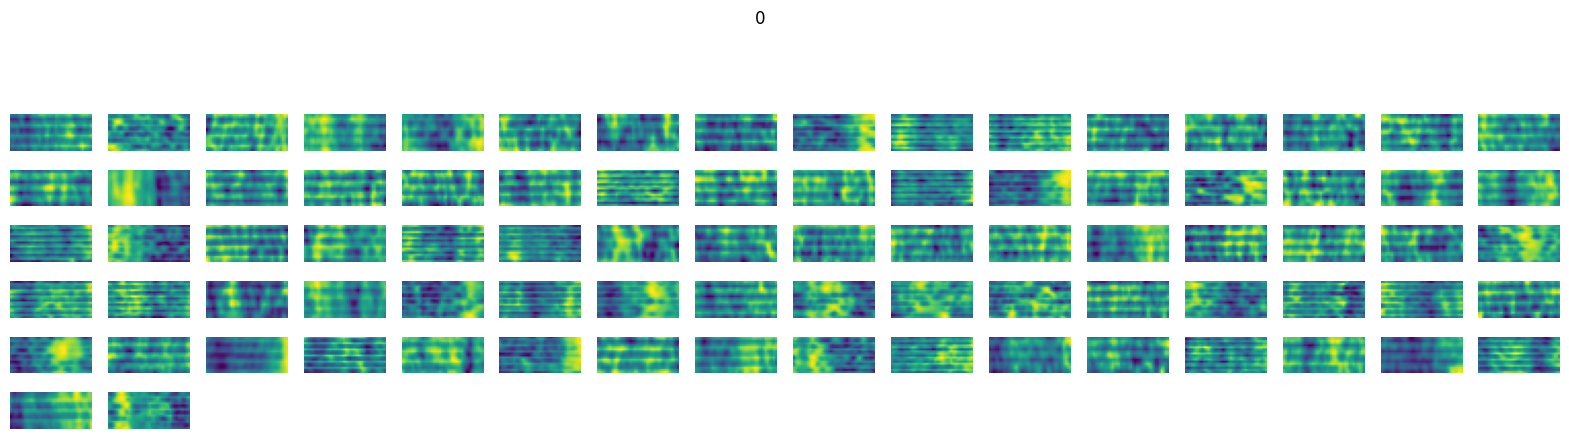

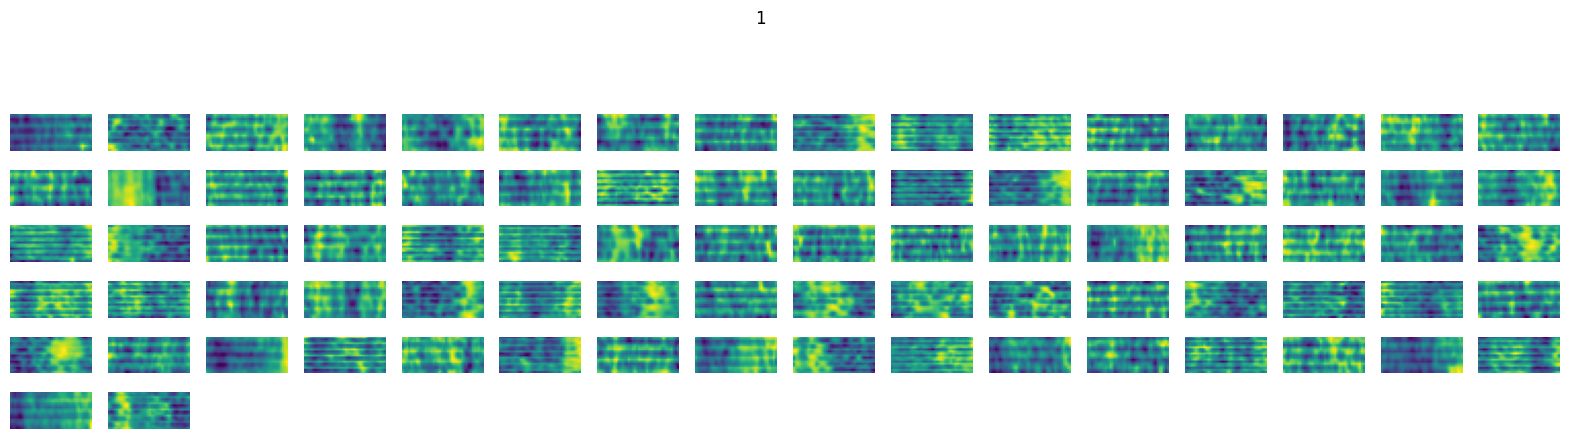

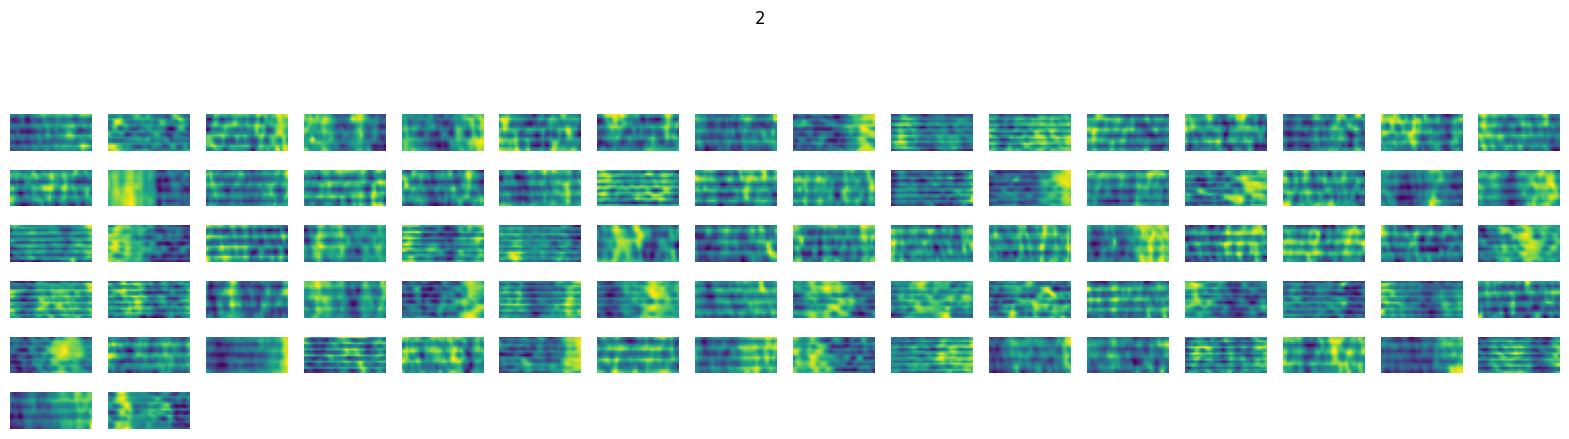

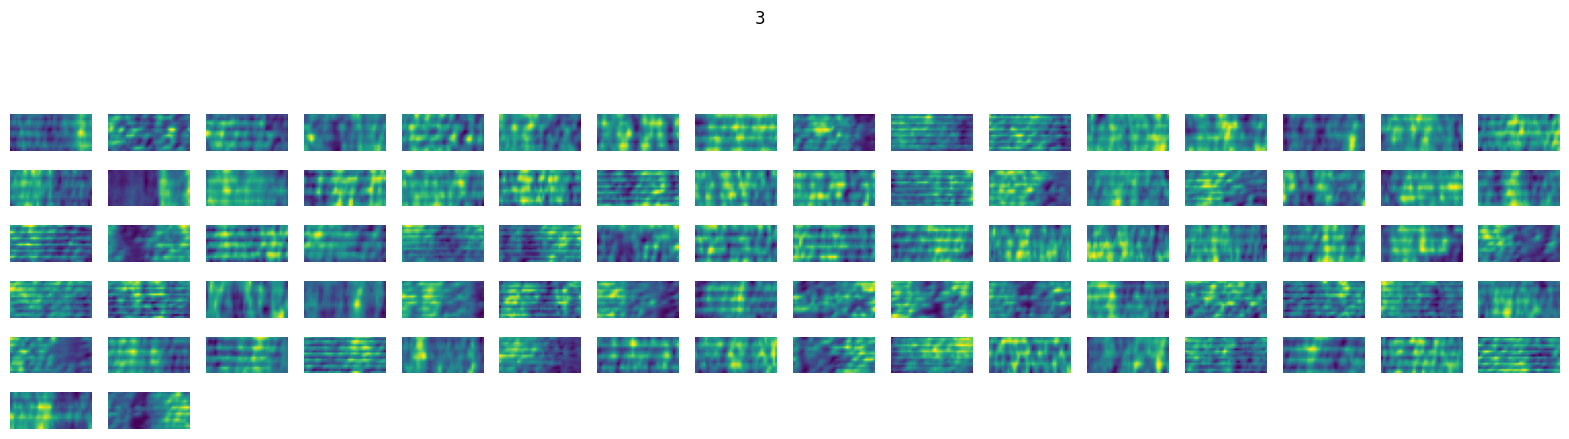

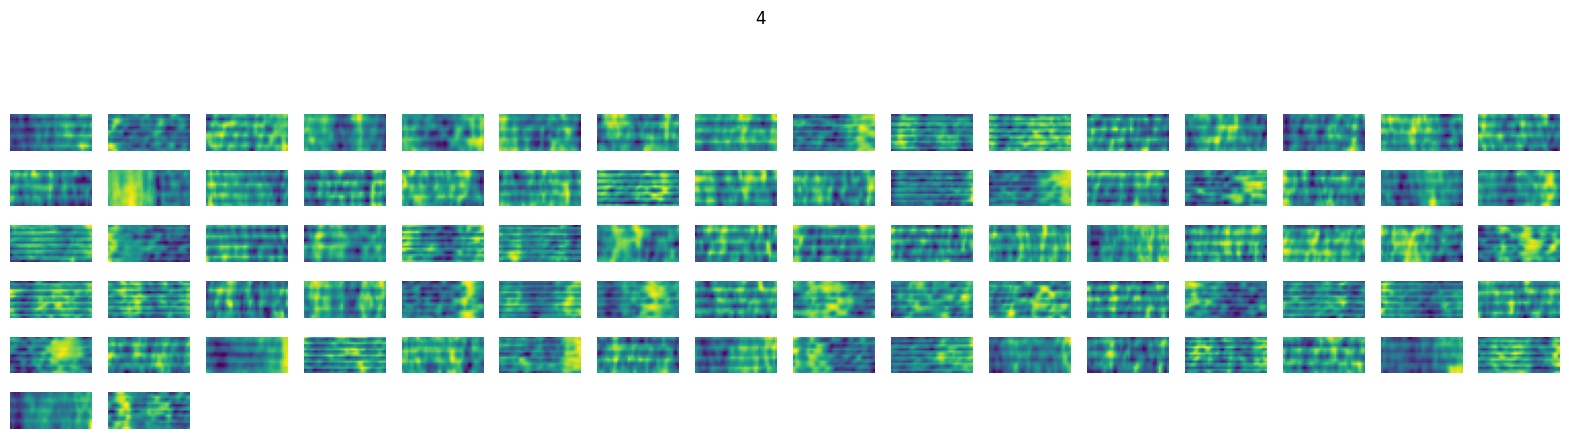

In [13]:
# Plot standardized images for visual confirmation
j = 0

for channel in range(xTrainScaled.shape[-1]):
    plt.figure(figsize=(20, 10))
    i = 1
    for k in np.arange(0, xTrainScaled.shape[0], 1):
        plt.subplot(14, 16, i)
        plt.imshow(xTrainScaled[k, j, :, :, channel])
        plt.axis("off")
        plt.suptitle(channel)
        i += 1

del i, k, j, channel

In [14]:
dfTrain.groupby(["Experiment_Name", "Rice_Cultivar"]).count()

Plot_Number  Nitrogen_Rate  Replicate  \
Experiment_Name   Rice_Cultivar                                            
Hybrid_RT7521FP   RT7521FP                  20             20         20   
Inbred_Jeff + NIL Jefferson                 10             10         10   
                  NIL 43                    10             10         10   
Mini_Core         EMBRAPA 1200               3              3          3   
                  Jefferson                  3              3          3   
                  M-202                      3              3          3   
                  RT7521FP                   3              3          3   
                  WAB462-10-3-1              3              3          3   
Santee_Gold       Carolina Gold              6              6          6   
                  Charleston Gold            6              6          6   
                  RoyJ                       6              6          6   
                  Santee Gold                6              6          6   
Tiara             IAC600                     6              6          6   
                  Scarlett                   6              6          6   
                  Sierra                     6              6          6   
                  Tiara                      6              6          6   

                                   Yield  
Experiment_Name   Rice_Cultivar           
Hybrid_RT7521FP   RT7521FP            20  
Inbred_Jeff + NIL Jefferson           10  
                  NIL 43              10  
Mini_Core         EMBRAPA 1200         3  
                  Jefferson            3  
                  M-202                3  
                  RT7521FP             3  
                  WAB462-10-3-1        3  
Santee_Gold       Carolina Gold        6  
                  Charleston Gold      6  
                  RoyJ                 6  
                  Santee Gold          6  
Tiara             IAC600               6  
                  Scarlett             6  
                  Sierra               6  
                  Tiara                6

In [15]:
dfTrain.iloc[sample[0]].groupby(["Experiment_Name", "Rice_Cultivar"]).count()

Plot_Number  Nitrogen_Rate  Replicate  \
Experiment_Name   Rice_Cultivar                                            
Hybrid_RT7521FP   RT7521FP                  16             16         16   
Inbred_Jeff + NIL Jefferson                  8              8          8   
                  NIL 43                     8              8          8   
Mini_Core         EMBRAPA 1200               2              2          2   
                  Jefferson                  2              2          2   
                  M-202                      2              2          2   
                  RT7521FP                   2              2          2   
                  WAB462-10-3-1              2              2          2   
Santee_Gold       Carolina Gold              5              5          5   
                  Charleston Gold            5              5          5   
                  RoyJ                       5              5          5   
                  Santee Gold                5              5          5   
Tiara             IAC600                     5              5          5   
                  Scarlett                   5              5          5   
                  Sierra                     5              5          5   
                  Tiara                      5              5          5   

                                   Yield  
Experiment_Name   Rice_Cultivar           
Hybrid_RT7521FP   RT7521FP            16  
Inbred_Jeff + NIL Jefferson            8  
                  NIL 43               8  
Mini_Core         EMBRAPA 1200         2  
                  Jefferson            2  
                  M-202                2  
                  RT7521FP             2  
                  WAB462-10-3-1        2  
Santee_Gold       Carolina Gold        5  
                  Charleston Gold      5  
                  RoyJ                 5  
                  Santee Gold          5  
Tiara             IAC600               5  
                  Scarlett             5  
                  Sierra               5  
                  Tiara                5

In [16]:
dfTrain.iloc[sample[1]].groupby(["Experiment_Name", "Rice_Cultivar"]).count()

Plot_Number  Nitrogen_Rate  Replicate  \
Experiment_Name   Rice_Cultivar                                            
Hybrid_RT7521FP   RT7521FP                   4              4          4   
Inbred_Jeff + NIL Jefferson                  2              2          2   
                  NIL 43                     2              2          2   
Mini_Core         EMBRAPA 1200               1              1          1   
                  Jefferson                  1              1          1   
                  M-202                      1              1          1   
                  RT7521FP                   1              1          1   
                  WAB462-10-3-1              1              1          1   
Santee_Gold       Carolina Gold              1              1          1   
                  Charleston Gold            1              1          1   
                  RoyJ                       1              1          1   
                  Santee Gold                1              1          1   
Tiara             IAC600                     1              1          1   
                  Scarlett                   1              1          1   
                  Sierra                     1              1          1   
                  Tiara                      1              1          1   

                                   Yield  
Experiment_Name   Rice_Cultivar           
Hybrid_RT7521FP   RT7521FP             4  
Inbred_Jeff + NIL Jefferson            2  
                  NIL 43               2  
Mini_Core         EMBRAPA 1200         1  
                  Jefferson            1  
                  M-202                1  
                  RT7521FP             1  
                  WAB462-10-3-1        1  
Santee_Gold       Carolina Gold        1  
                  Charleston Gold      1  
                  RoyJ                 1  
                  Santee Gold          1  
Tiara             IAC600               1  
                  Scarlett             1  
                  Sierra               1  
                  Tiara                1

#### Plot Yield Distributions


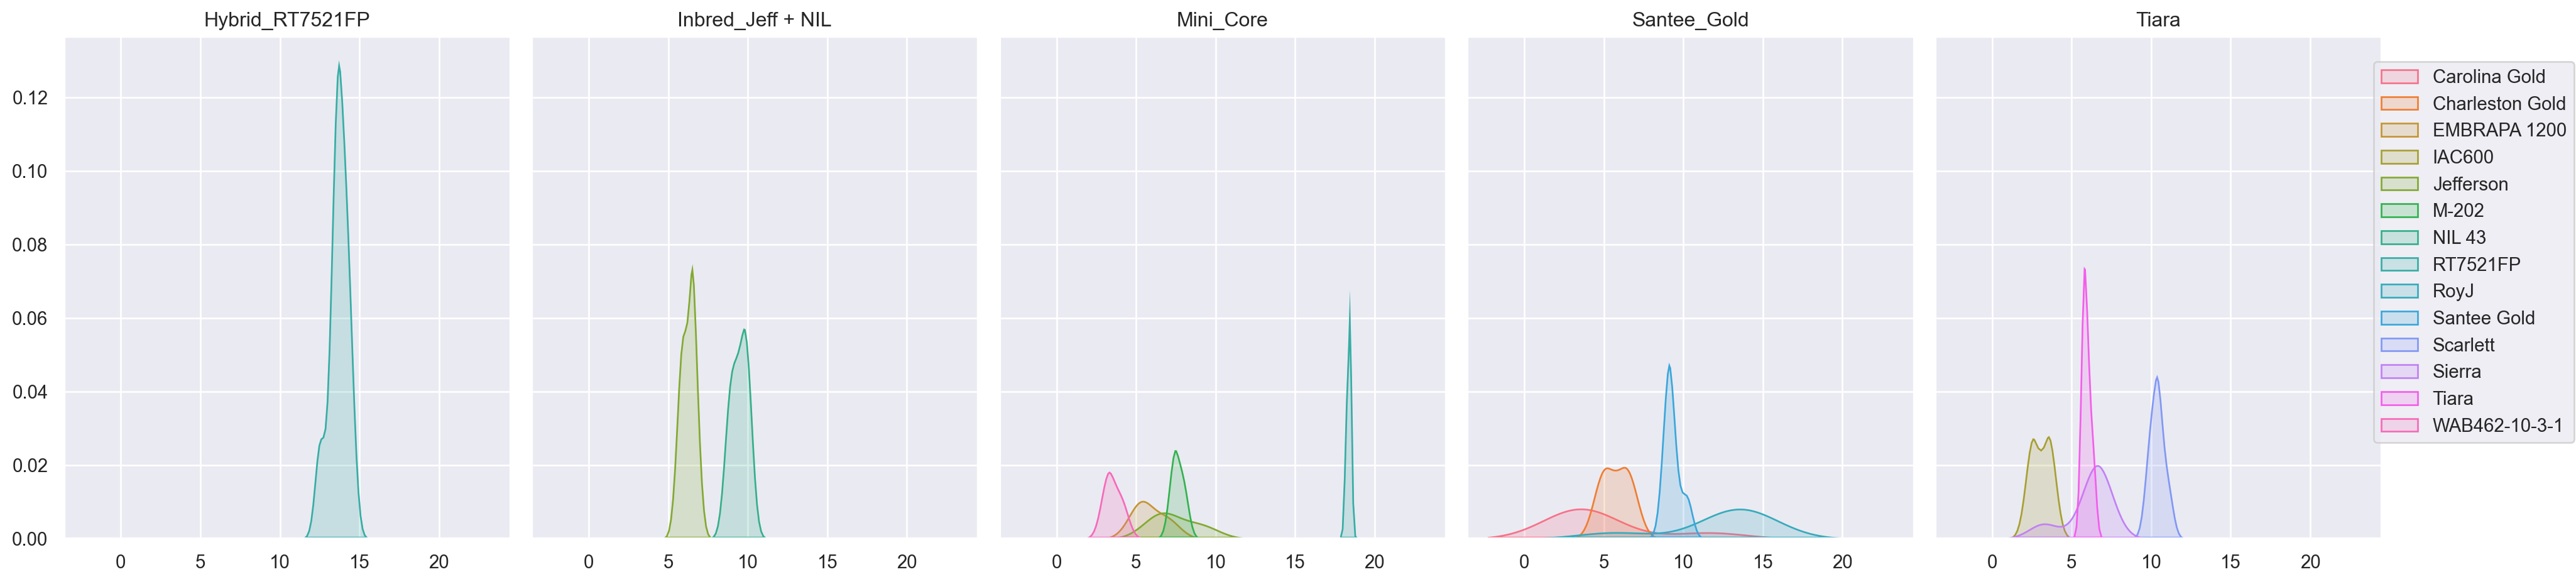

In [19]:
# original
(
    so.Plot(dfTrain, x="Yield", color="Rice_Cultivar")
    .layout(size=(20, 5))
    .facet(
        col="Experiment_Name",
        order=[
            "Hybrid_RT7521FP",
            "Inbred_Jeff + NIL",
            "Mini_Core",
            "Santee_Gold",
            "Tiara",
        ],
    )
    .add(so.Area(), so.KDE())
    .label(x="", color="")
    .scale(color=so.Nominal(order=sorted(dfTrain["Rice_Cultivar"].unique())))
    # .scale(color="Spectral")
)

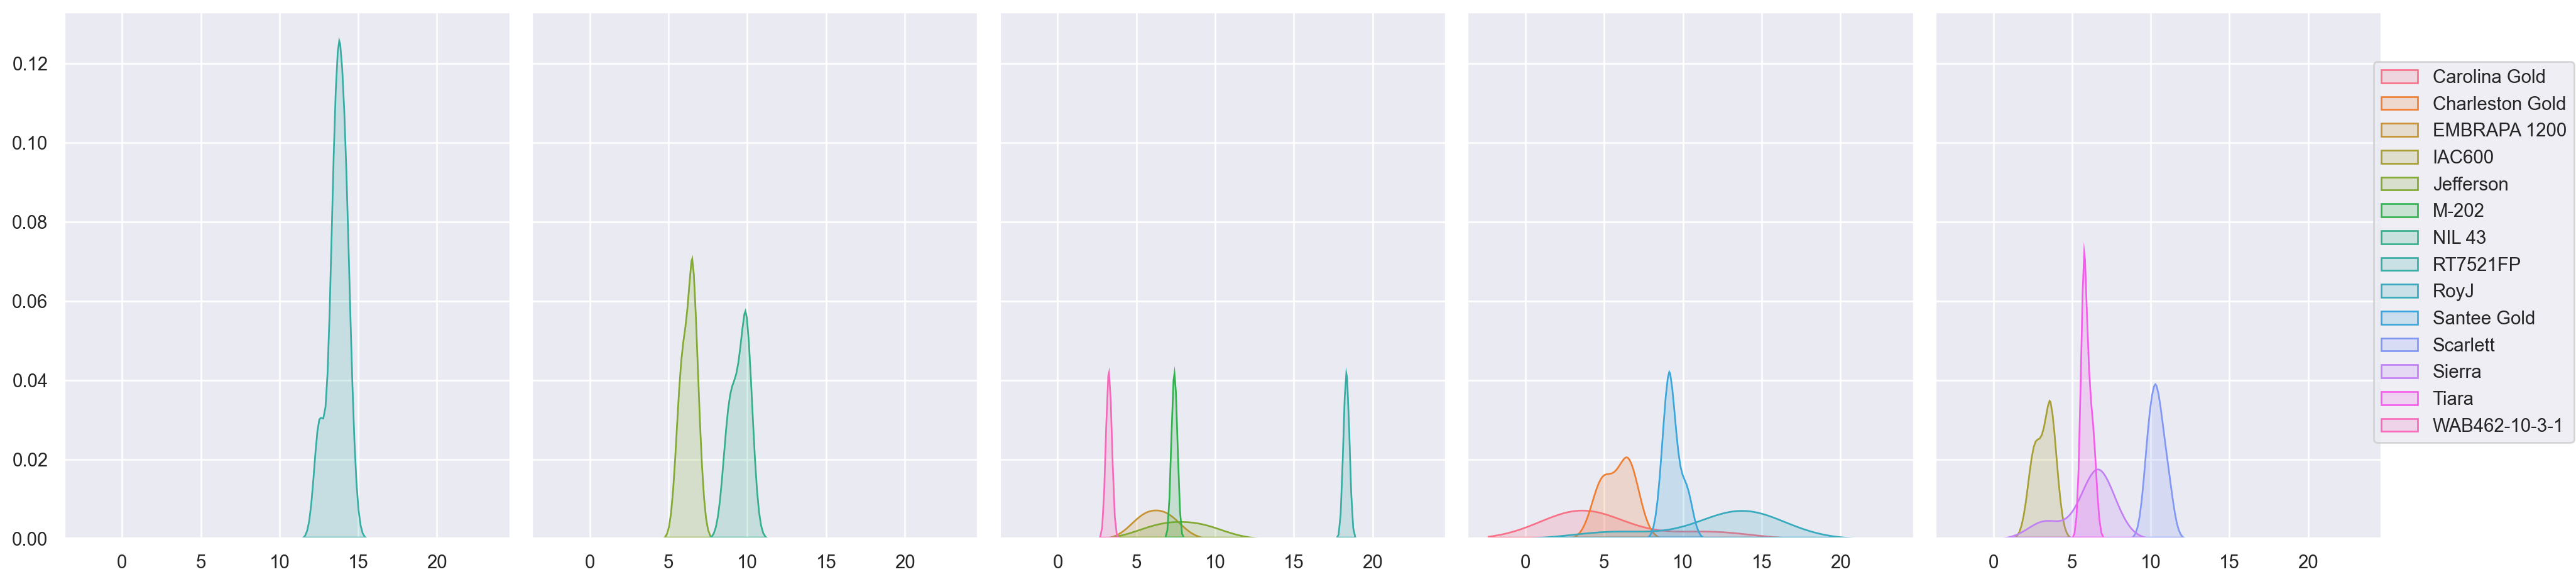

In [20]:
# train
(
    so.Plot(dfTrain.iloc[sample[0]], x="Yield", color="Rice_Cultivar")
    .layout(size=(20, 5))
    .facet(
        col="Experiment_Name",
        order=[
            "Hybrid_RT7521FP",
            "Inbred_Jeff + NIL",
            "Mini_Core",
            "Santee_Gold",
            "Tiara",
        ],
    )
    .add(so.Area(), so.KDE())
    .label(x="", color="", title="")
    .scale(color=so.Nominal(order=sorted(dfTrain["Rice_Cultivar"].unique())))
    # .scale(color="Spectral")
)

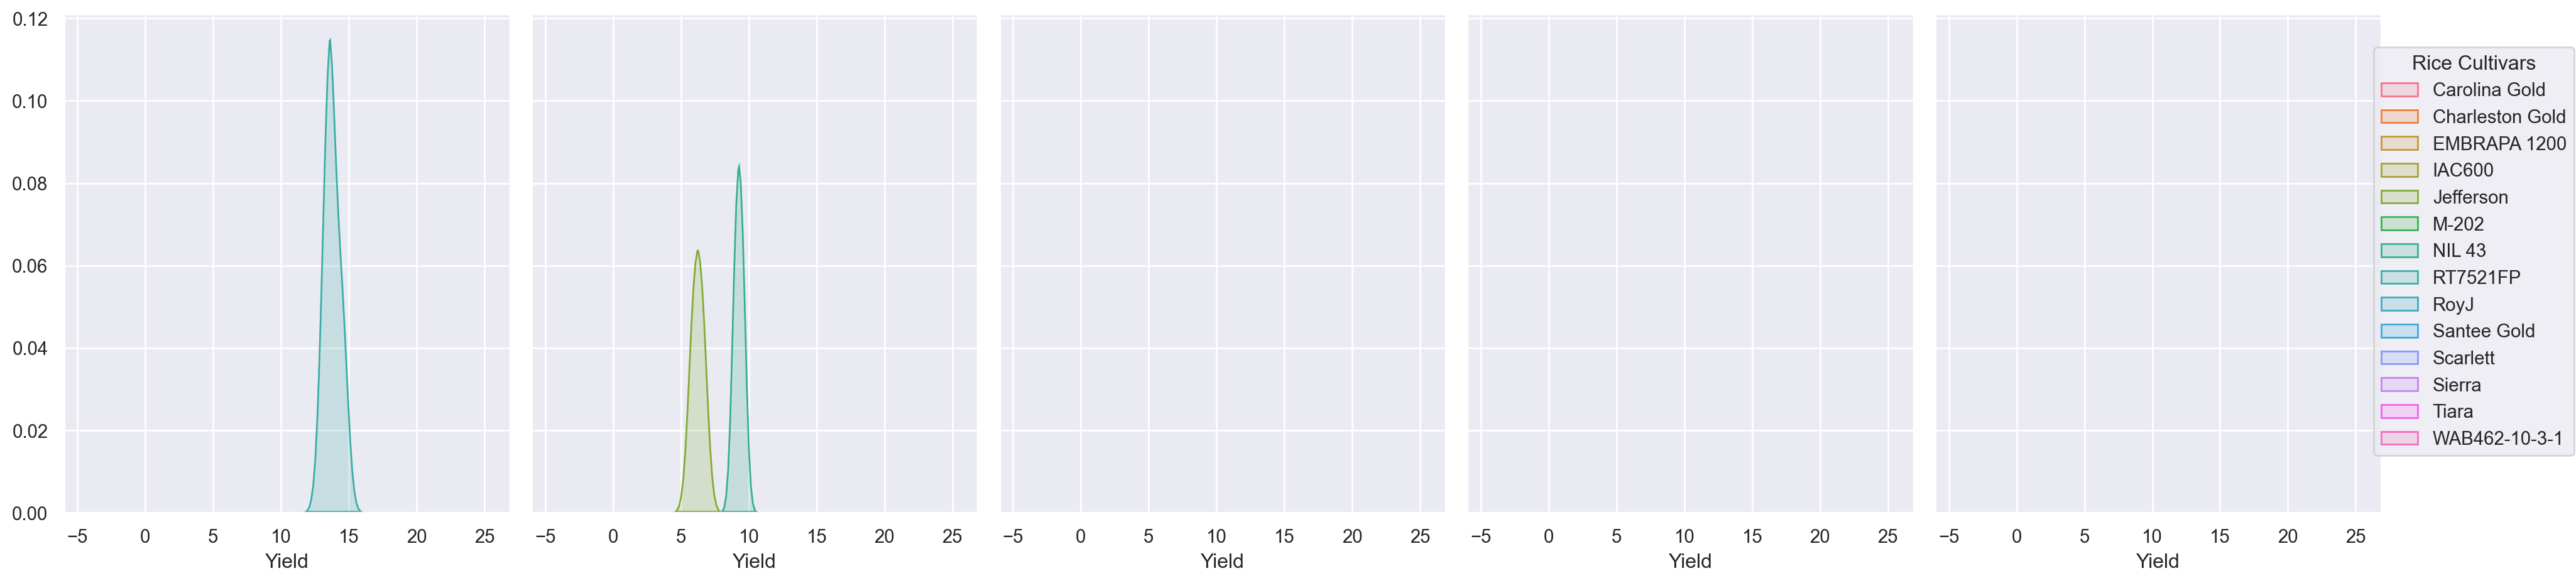

In [21]:
# val
(
    so.Plot(dfTrain.iloc[sample[1]], x="Yield", color="Rice_Cultivar")
    .layout(size=(20, 5))
    .facet(
        col="Experiment_Name",
        order=[
            "Hybrid_RT7521FP",
            "Inbred_Jeff + NIL",
            "Mini_Core",
            "Santee_Gold",
            "Tiara",
        ],
    )
    .label(x="Yield", color="Rice Cultivars", title="")
    .add(so.Area(), so.KDE())
    .scale(color=so.Nominal(order=sorted(dfTrain["Rice_Cultivar"].unique())))
)

#### Custom Data Augmentation


In [71]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    "Generates data for Keras"

    def __init__(
        self,
        X,
        y,
        batch_size=28,
        dim=(N_TIMEPOINTS, 18, 40),
        n_channels=5,
        shuffle=False,
        augment=False,
    ):
        "Initialization"
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        "Denotes the number of batches per epoch"
        # return int(np.floor(len(self.X) / self.batch_size))
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        "Generate one batch of data"
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        "Updates indexes after each epoch"
        self.indexes = np.arange(self.X.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, X_temp):
        "Generates data containing batch_size samples"
        trueSize = len(X_temp)
        X = np.empty((trueSize, *self.dim, self.n_channels))
        y = np.empty(trueSize, dtype=float)

        # Generate data
        for i, index in enumerate(X_temp):
            # Store sample
            X[i,] = self.X[index]

            # Store yield label
            y[i] = self.y[index]

        if self.augment:
            X = self.augment_images(X)

        return X, y

    def augment_images(self, imgs):
        "Randomly applies augmentation to images"
        for i in range(len(imgs)):
            lefRightProb = tf.random.uniform([]).numpy() > 0.5
            upDownProb = tf.random.uniform([]).numpy() > 0.5
            rotateProb = tf.random.uniform([]).numpy() > 0.5
            scaleProb = tf.random.uniform([]).numpy() > 0.5

            rotateAngle = tf.random.uniform([], minval=-25, maxval=25).numpy()
            scaleFactor = tf.random.uniform([], minval=0.6, maxval=1.4).numpy()

            # apply same augmentation to each timepoint of a single plot
            for timepoint in range(imgs[i].shape[0]):
                imgs[i, timepoint] = tf.cond(
                    lefRightProb,
                    lambda: imgaug.augmenters.flip.fliplr(imgs[i, timepoint]),
                    lambda: imgs[i, timepoint],
                )

                imgs[i, timepoint] = tf.cond(
                    upDownProb,
                    lambda: imgaug.augmenters.flip.flipud(imgs[i, timepoint]),
                    lambda: imgs[i, timepoint],
                )

                imgs[i, timepoint] = tf.cond(
                    rotateProb,
                    lambda: imgaug.augmenters.geometric.Affine(
                        rotate=rotateAngle,
                        mode="reflect",
                    )(image=imgs[i, timepoint]),
                    lambda: imgs[i, timepoint],
                )

                imgs[i, timepoint] = tf.cond(
                    scaleProb,
                    lambda: imgaug.augmenters.geometric.Affine(
                        scale=scaleFactor,
                        mode="reflect",
                    )(image=imgs[i, timepoint]),
                    lambda: imgs[i, timepoint],
                )

        return imgs

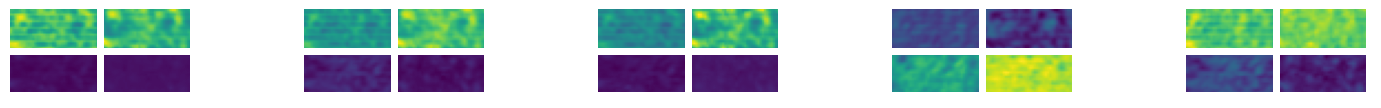

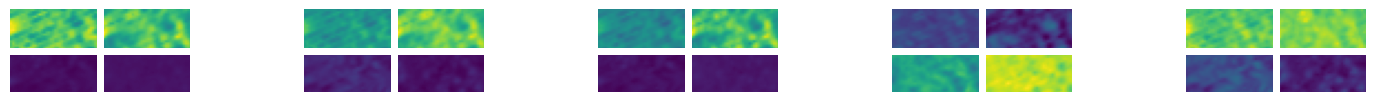

In [77]:
padding = 2
temp = np.stack((xTrainScaled[1], test[0][1]), axis=0)

# Iterate through the layers and feature maps
for img in temp:
    if len(img.shape) == 4:
        numFilters = img.shape[-1]
        numRows = 8  # Number of rows for sub-squares
        numCols = 8  # Number of columns for sub-squares

        fig = plt.figure(figsize=(30, 10))

        for i in range(numFilters):
            ax = fig.add_subplot(numRows, numCols, i + 1)

            # Stack the frames from the feature map
            stackedImage = img[:, :, :, i]

            # Calculate the dimensions for sub-squares with padding
            subSquareSize = (
                stackedImage.shape[1] + padding,
                stackedImage.shape[2] + padding,
            )

            # Create a canvas for arranging the sub-squares
            canvas = np.ones((2 * subSquareSize[0], 2 * subSquareSize[1])) * np.nan

            # Place each frame in a sub-square with padding
            for j in range(stackedImage.shape[0]):
                row = j // 2
                col = j % 2
                frame = stackedImage[j, :, :]
                canvas[
                    row * subSquareSize[0] : (row + 1) * subSquareSize[0] - padding,
                    col * subSquareSize[1] : (col + 1) * subSquareSize[1] - padding,
                ] = frame

            ax.imshow(canvas, cmap="viridis")
            # ax.set_title(f"Filter {i + 1}")
            ax.axis("off")

        plt.subplots_adjust(
            wspace=0.1, hspace=0.1
        )  # Adjust spacing between sub-squares
        plt.show()

#### Build 3D-CNN Architecture


In [78]:
tf.keras.backend.clear_session()
gc.collect()

inputShape = xTrainScaled.shape[1:]
model = tf.keras.Sequential(
    [
        layers.Input(shape=inputShape),
        # conv 1
        layers.Conv3D(
            256,
            kernel_size=(1, 3, 4),
            activation="relu",
            padding="same",
        ),
        layers.BatchNormalization(momentum=0.99),
        layers.MaxPooling3D((1, 3, 1)),
        # conv 2
        layers.Conv3D(
            256,
            kernel_size=(4, 2, 2),
            activation="relu",
            padding="same",
        ),
        layers.BatchNormalization(momentum=0.99),
        layers.SpatialDropout3D(0.1),
        layers.MaxPooling3D((1, 1, 3)),
        # conv 3
        layers.Conv3D(
            64,
            kernel_size=(4, 2, 4),
            activation="relu",
            padding="same",
        ),
        layers.BatchNormalization(momentum=0.99),
        # conv 4
        layers.Conv3D(
            128,
            kernel_size=(2, 2, 4),
            activation="relu",
            padding="same",
        ),
        layers.BatchNormalization(momentum=0.99),
        layers.SpatialDropout3D(0.1),
        ###########################################
        layers.Flatten(),
        # # dense 1
        layers.Dense(64, activation="relu"),
        # # dense 2
        layers.Dense(64, activation="relu"),
        ###########################################
        # output layer
        layers.Dense(1, activation="linear"),
    ]
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss="mse",
    metrics=[
        tf.keras.metrics.RootMeanSquaredError(),
        tf.keras.metrics.MeanAbsoluteError(),
    ],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 4, 18, 40, 256)    15616     
                                                                 
 batch_normalization (BatchN  (None, 4, 18, 40, 256)   1024      
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 4, 6, 40, 256)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 4, 6, 40, 256)     1048832   
                                                                 
 batch_normalization_1 (Batc  (None, 4, 6, 40, 256)    1024      
 hNormalization)                                                 
                                                        

In [79]:
trainGenerator = CustomDataGenerator(
    xTrainScaled, yTrain, shuffle=True, augment=True, batch_size=16
)

valGenerator = CustomDataGenerator(
    xValScaled, yVal, shuffle=False, augment=False, batch_size=16
)

history = model.fit(
    trainGenerator,
    epochs=200,
    validation_data=valGenerator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=15, restore_best_weights=True
        ),
    ],
)

Epoch 1/200
6/6 [==============================] - 7s 753ms/step - loss: 27.1988 - root_mean_squared_error: 5.2152 - mean_absolute_error: 4.2563 - val_loss: 91.9192 - val_root_mean_squared_error: 9.5874 - val_mean_absolute_error: 8.6583
Epoch 2/200
6/6 [==============================] - 1s 241ms/step - loss: 12.5289 - root_mean_squared_error: 3.5396 - mean_absolute_error: 2.8922 - val_loss: 87.9057 - val_root_mean_squared_error: 9.3758 - val_mean_absolute_error: 8.4374
Epoch 3/200
6/6 [==============================] - 2s 257ms/step - loss: 8.8231 - root_mean_squared_error: 2.9704 - mean_absolute_error: 2.3059 - val_loss: 87.1421 - val_root_mean_squared_error: 9.3350 - val_mean_absolute_error: 8.4021
Epoch 4/200
6/6 [==============================] - 2s 277ms/step - loss: 6.9264 - root_mean_squared_error: 2.6318 - mean_absolute_error: 1.9989 - val_loss: 84.8511 - val_root_mean_squared_error: 9.2115 - val_mean_absolute_error: 8.2703
Epoch 5/200
6/6 [==============================] - 2s 

#### Visualize Errors


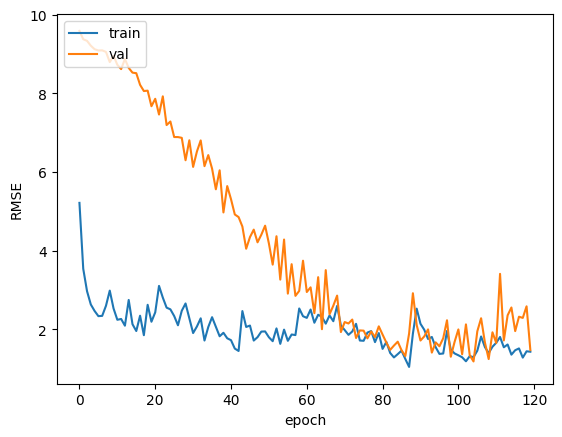

In [80]:
plt.plot(history.history["root_mean_squared_error"])
plt.plot(history.history["val_root_mean_squared_error"])
# plt.plot(history.history['val_loss'])
plt.ylabel("RMSE")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [81]:
trainPreds = model.predict(xTrainScaled)
trainDf = dfTrain.iloc[sample[0]].reset_index(drop=True)
trainDf["Yield_pred"] = trainPreds

valPreds = model.predict(xValScaled)
valDf = dfTrain.iloc[sample[1]].reset_index(drop=True)
valDf["Yield_pred"] = valPreds

print(f"Train RMSE: {mean_squared_error(yTrain, trainPreds, squared = False)}")
print(f"Train MAE: {mean_absolute_error(yTrain, trainPreds)}")
print(f"Train MBE: {np.mean(trainPreds - yTrain)}")
print("---------------------------------------------------------")
print(f"Val RMSE: {mean_squared_error(yVal, valPreds, squared = False)}")
print(f"Val MAE: {mean_absolute_error(yVal, valPreds)}")
print(f"Val MBE: {np.mean(valPreds - yVal)}")

1/1 [==============================] - 2s 2s/step
Train RMSE: 1.514747583099009
Train MAE: 1.2858714167215086
Train MBE: -1.242821268050381
---------------------------------------------------------
Val RMSE: 1.1832754896597633
Val MAE: 0.9610556866374393
Val MBE: -0.3244916860388762


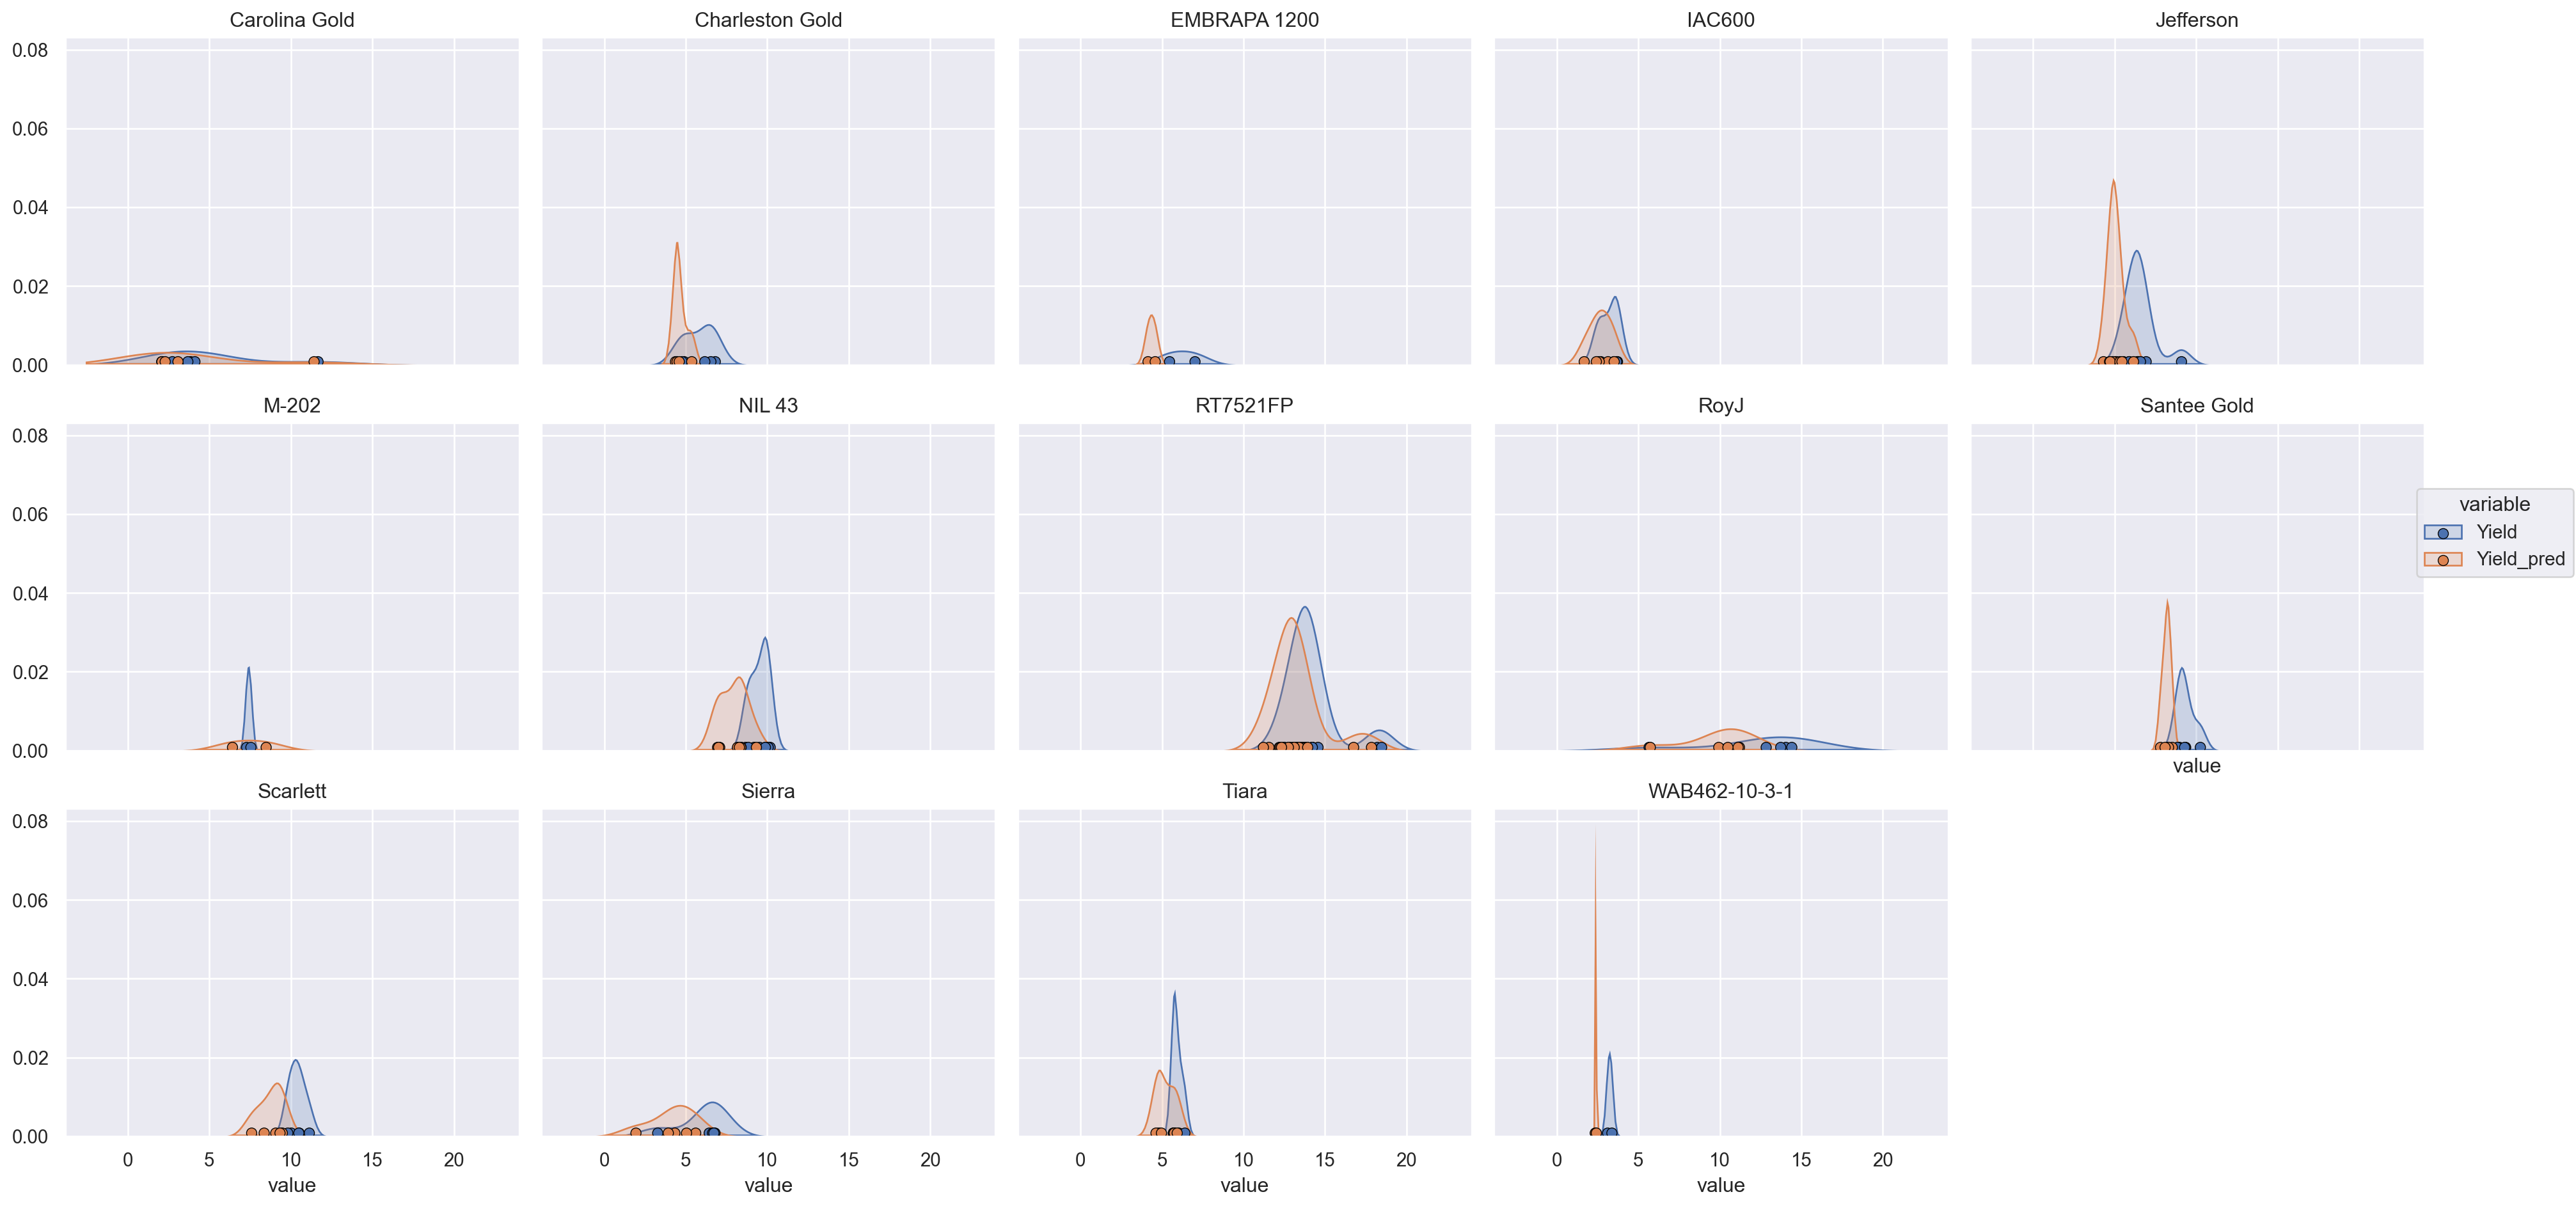

In [82]:
temp = pd.melt(
    trainDf, id_vars=trainDf.columns[:-2], value_vars=["Yield", "Yield_pred"]
)
(
    so.Plot(
        temp,
        x="value",
    )
    .layout(size=(20, 10))
    .facet(
        col="Rice_Cultivar",
        order=sorted(temp["Rice_Cultivar"].unique()),
        wrap=5,
    )
    .add(so.Area(), so.KDE(), color="variable")
    .add(so.Dot(edgecolor="black"), y=[0.0008] * len(temp), color="variable")
)

# del temp

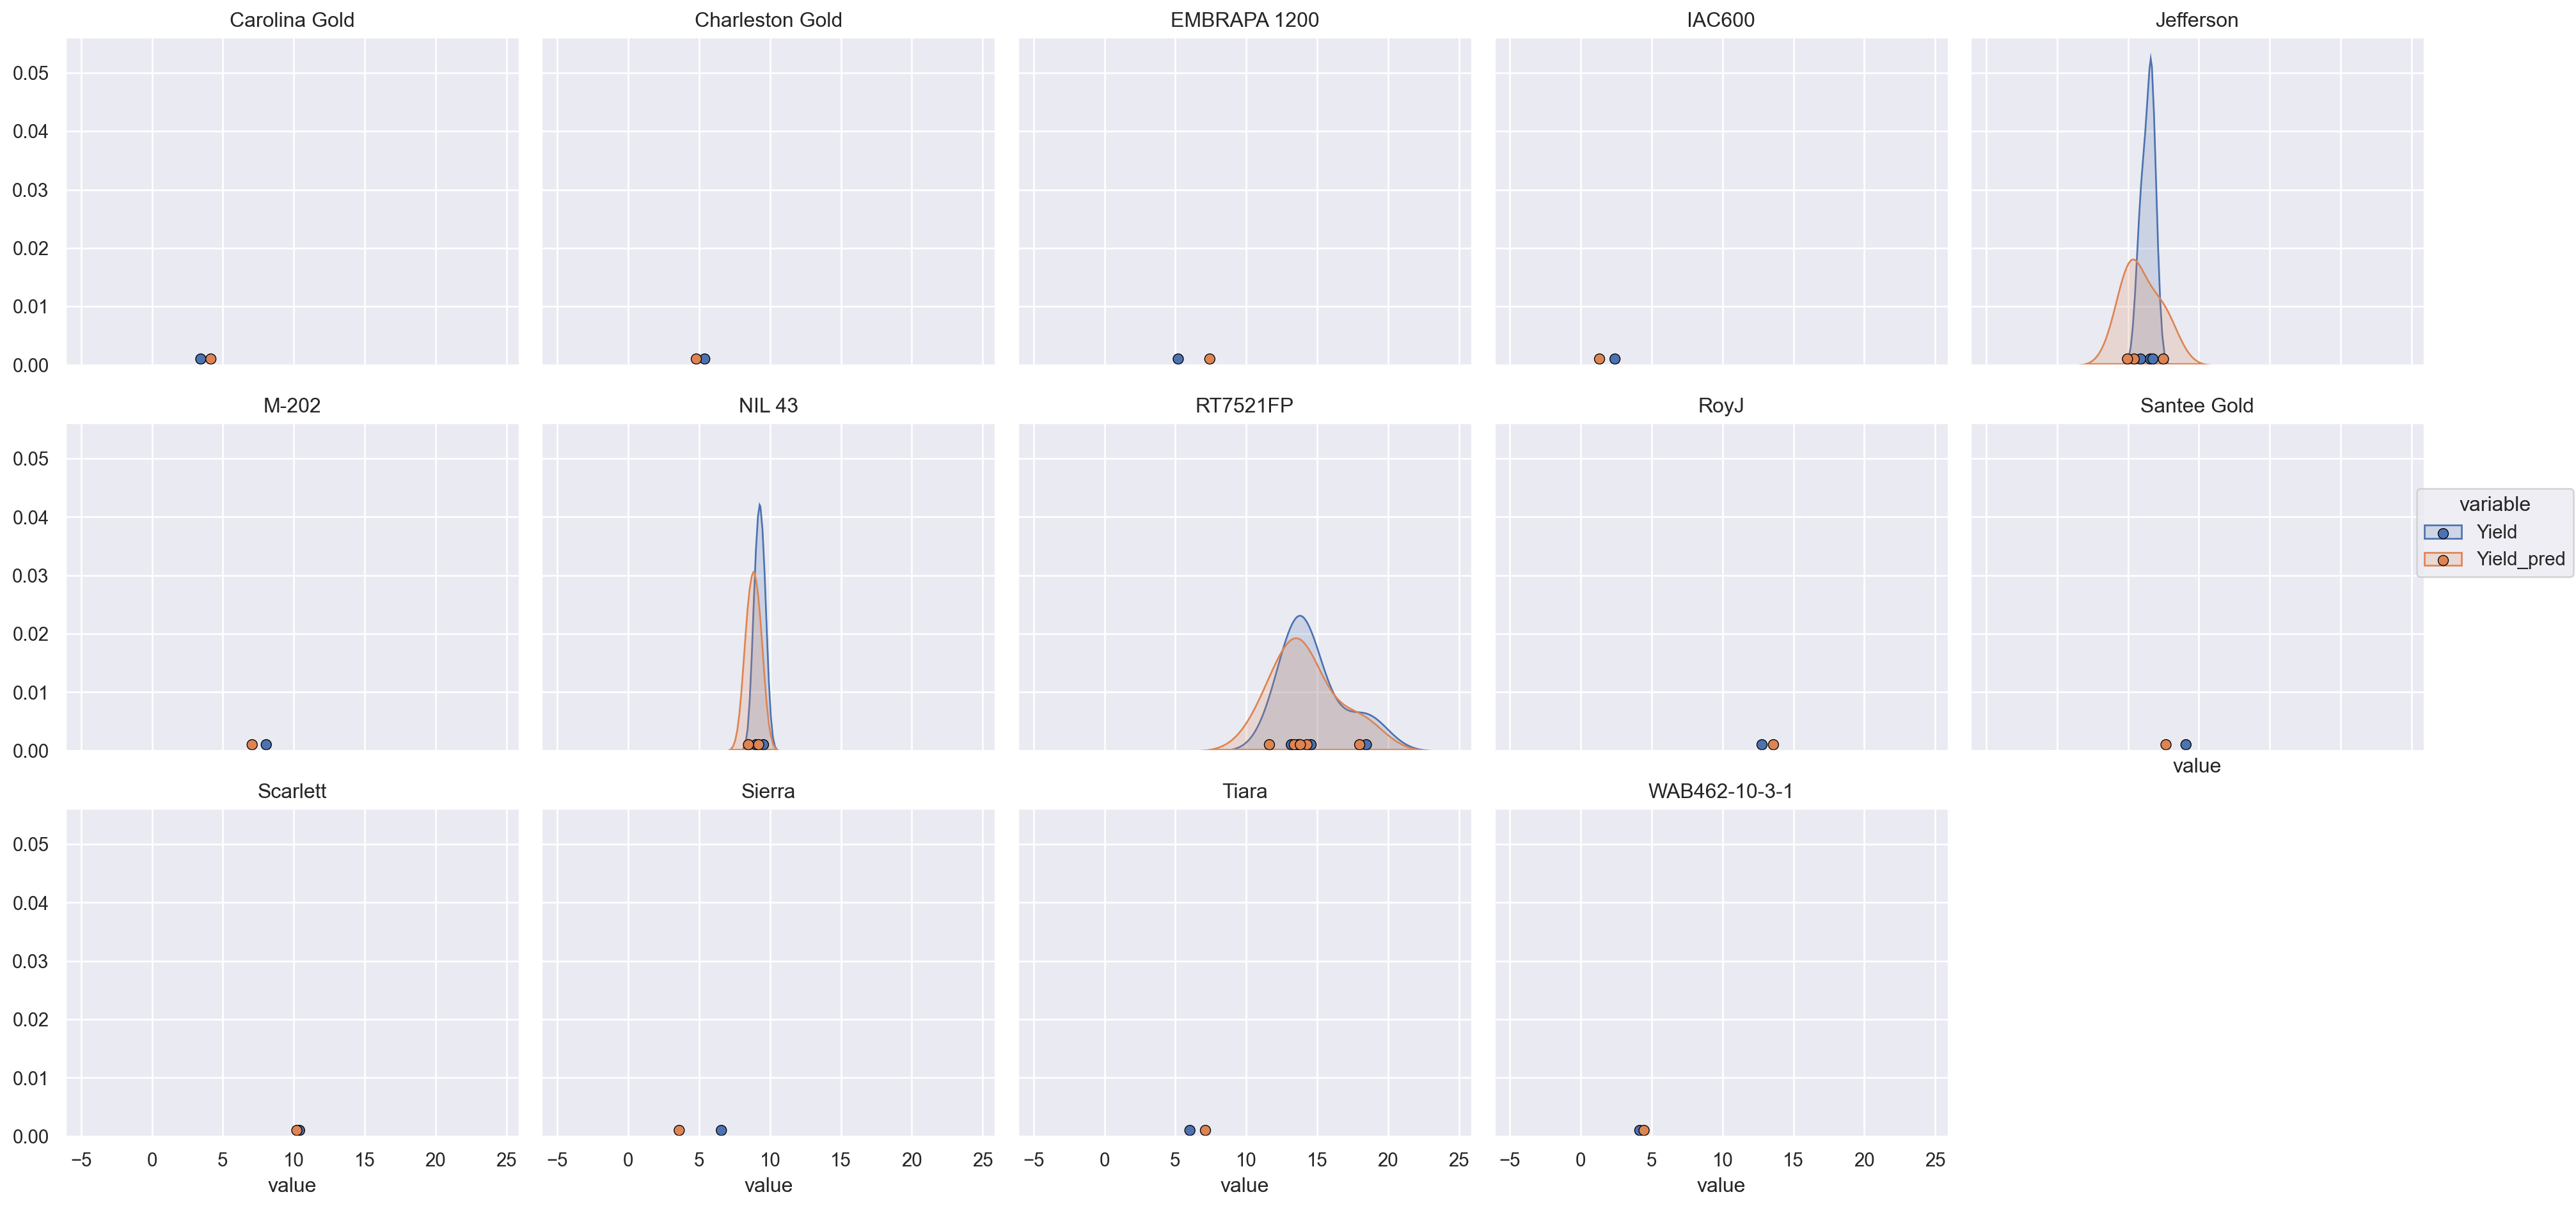

In [83]:
temp = pd.melt(valDf, id_vars=valDf.columns[:-2], value_vars=["Yield", "Yield_pred"])
(
    so.Plot(temp, x="value")
    .layout(size=(20, 10))
    .facet(
        col="Rice_Cultivar",
        order=sorted(temp["Rice_Cultivar"].unique()),
        wrap=5,
    )
    .add(so.Area(), so.KDE(), color="variable")
    .add(so.Dot(edgecolor="black"), y=[0.001] * len(temp), color="variable")
)

# del temp

In [84]:
featureMapsModel = tf.keras.models.Model(
    inputs=model.input, outputs=[layer.output for layer in model.layers[1:]]
)

featureMaps = featureMapsModel.predict(xValScaled)
layerNames = [layer.name for layer in model.layers]

1/1 [==============================] - 0s 146ms/step


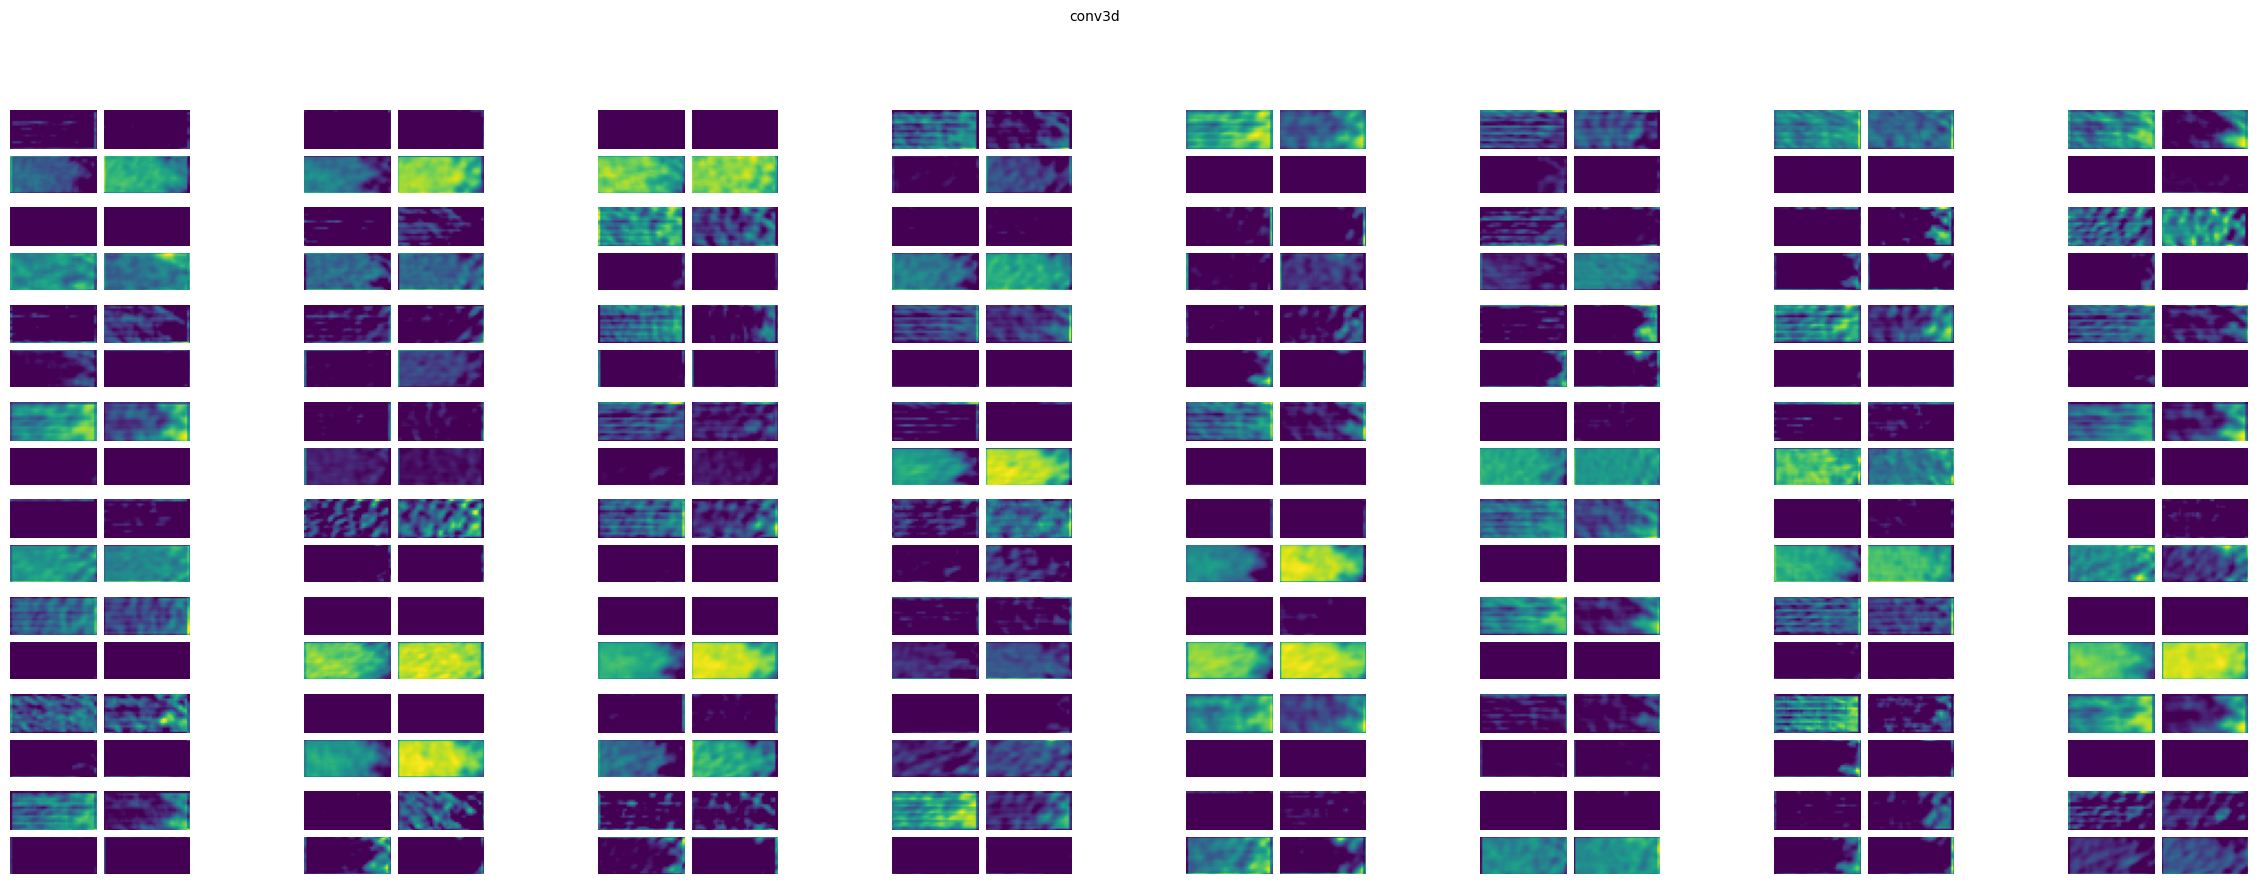

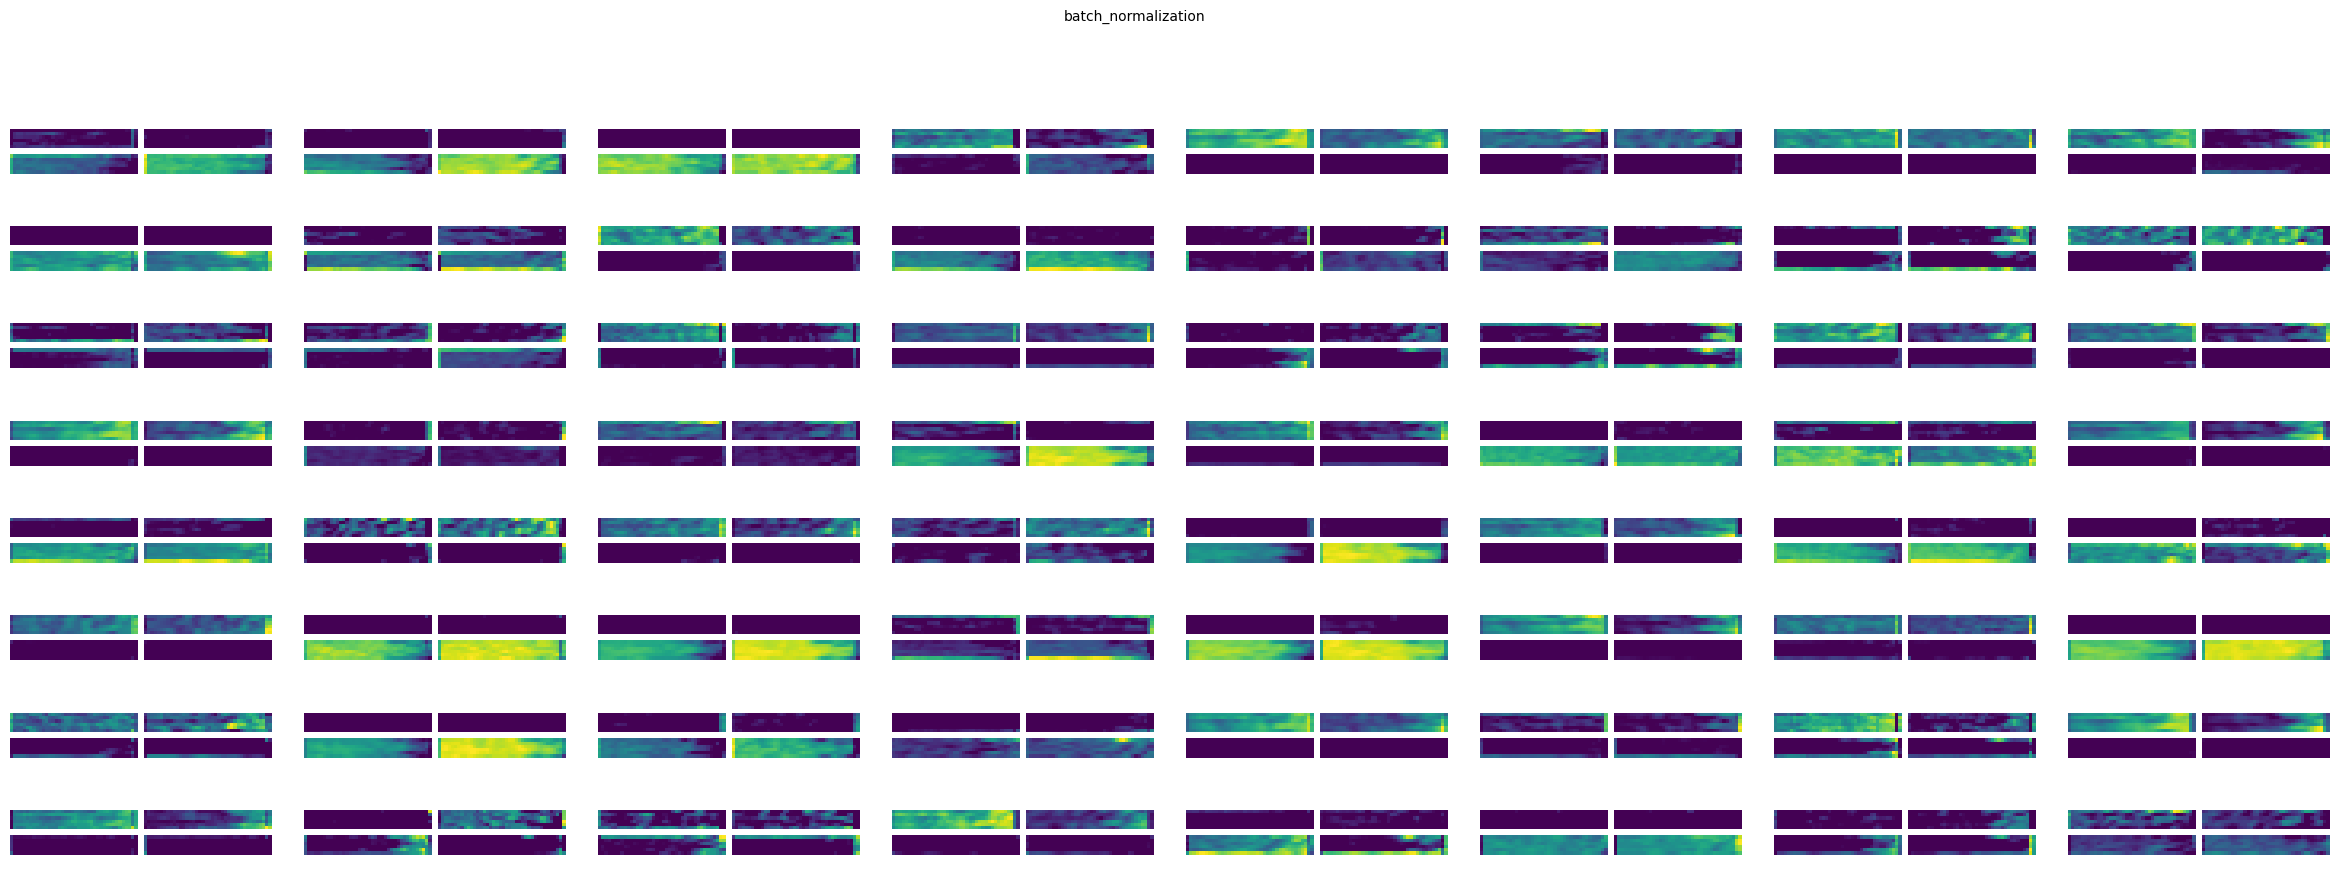

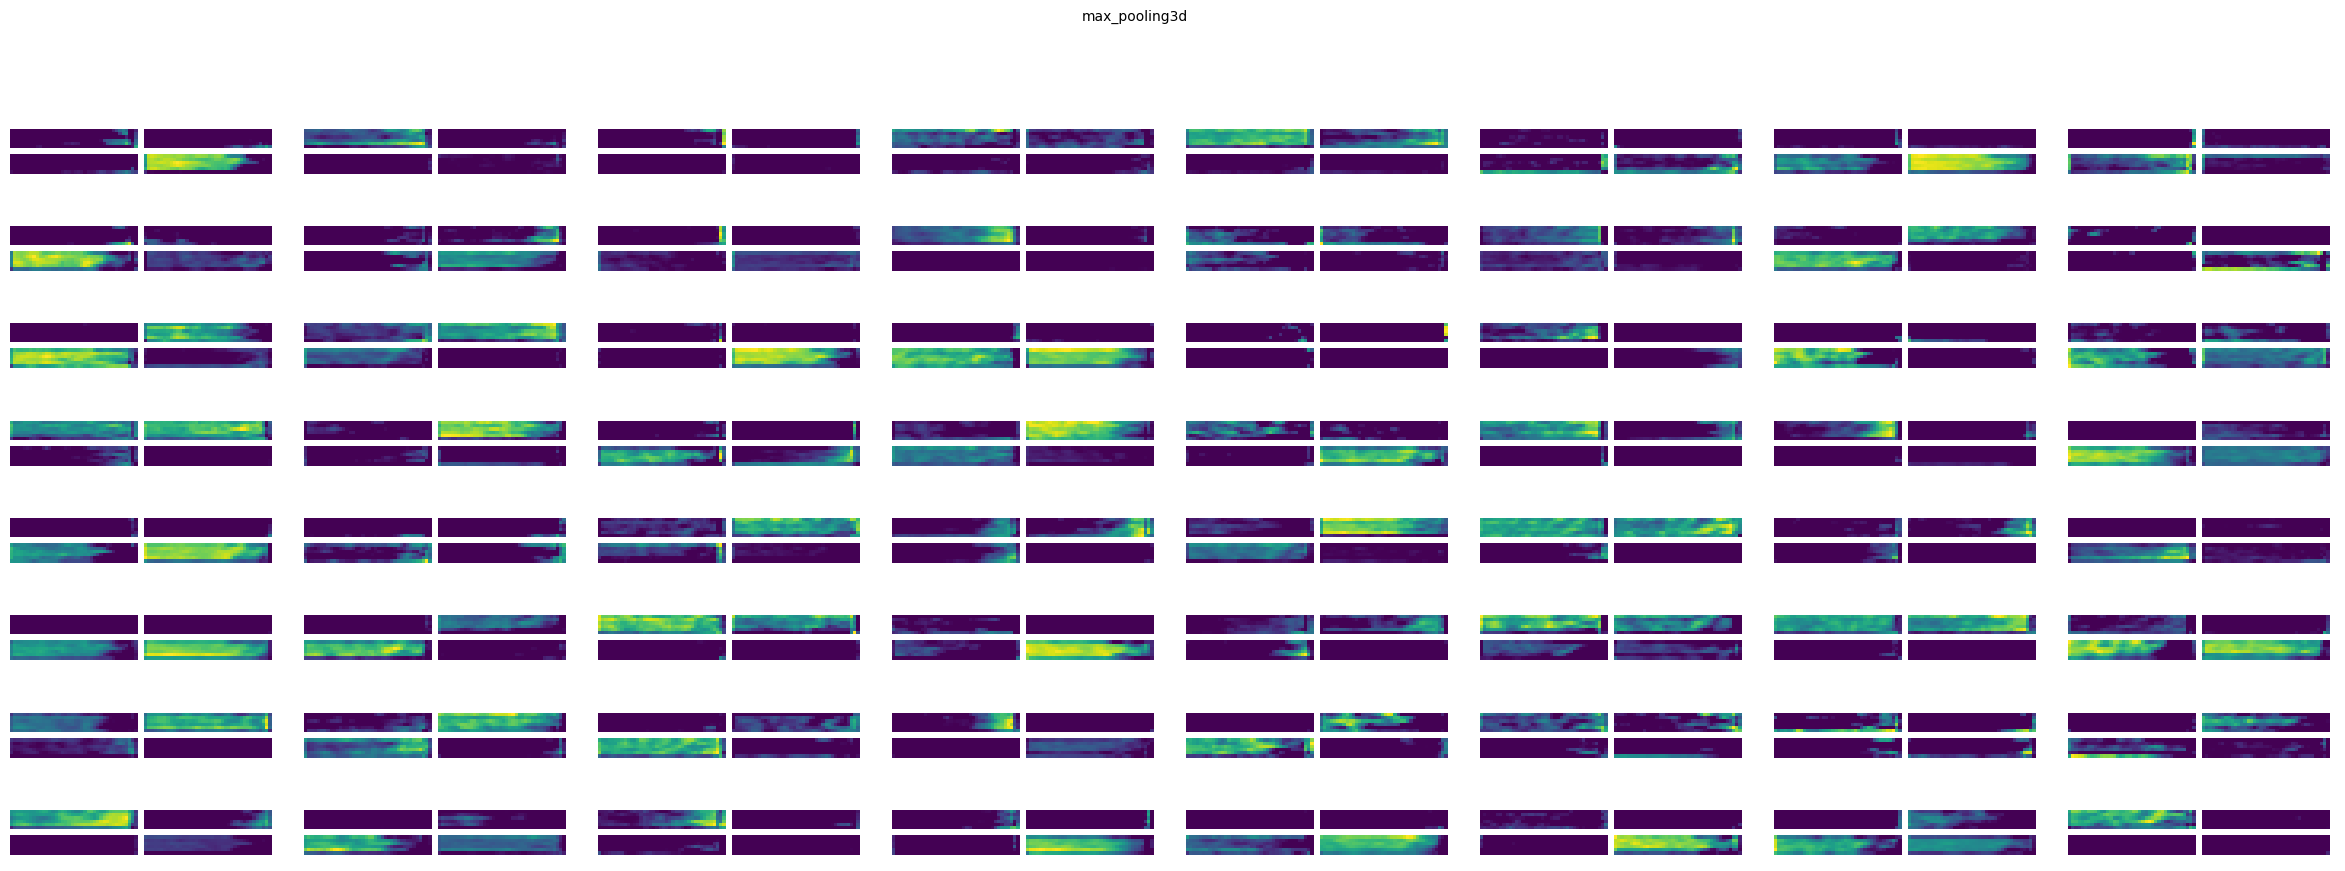

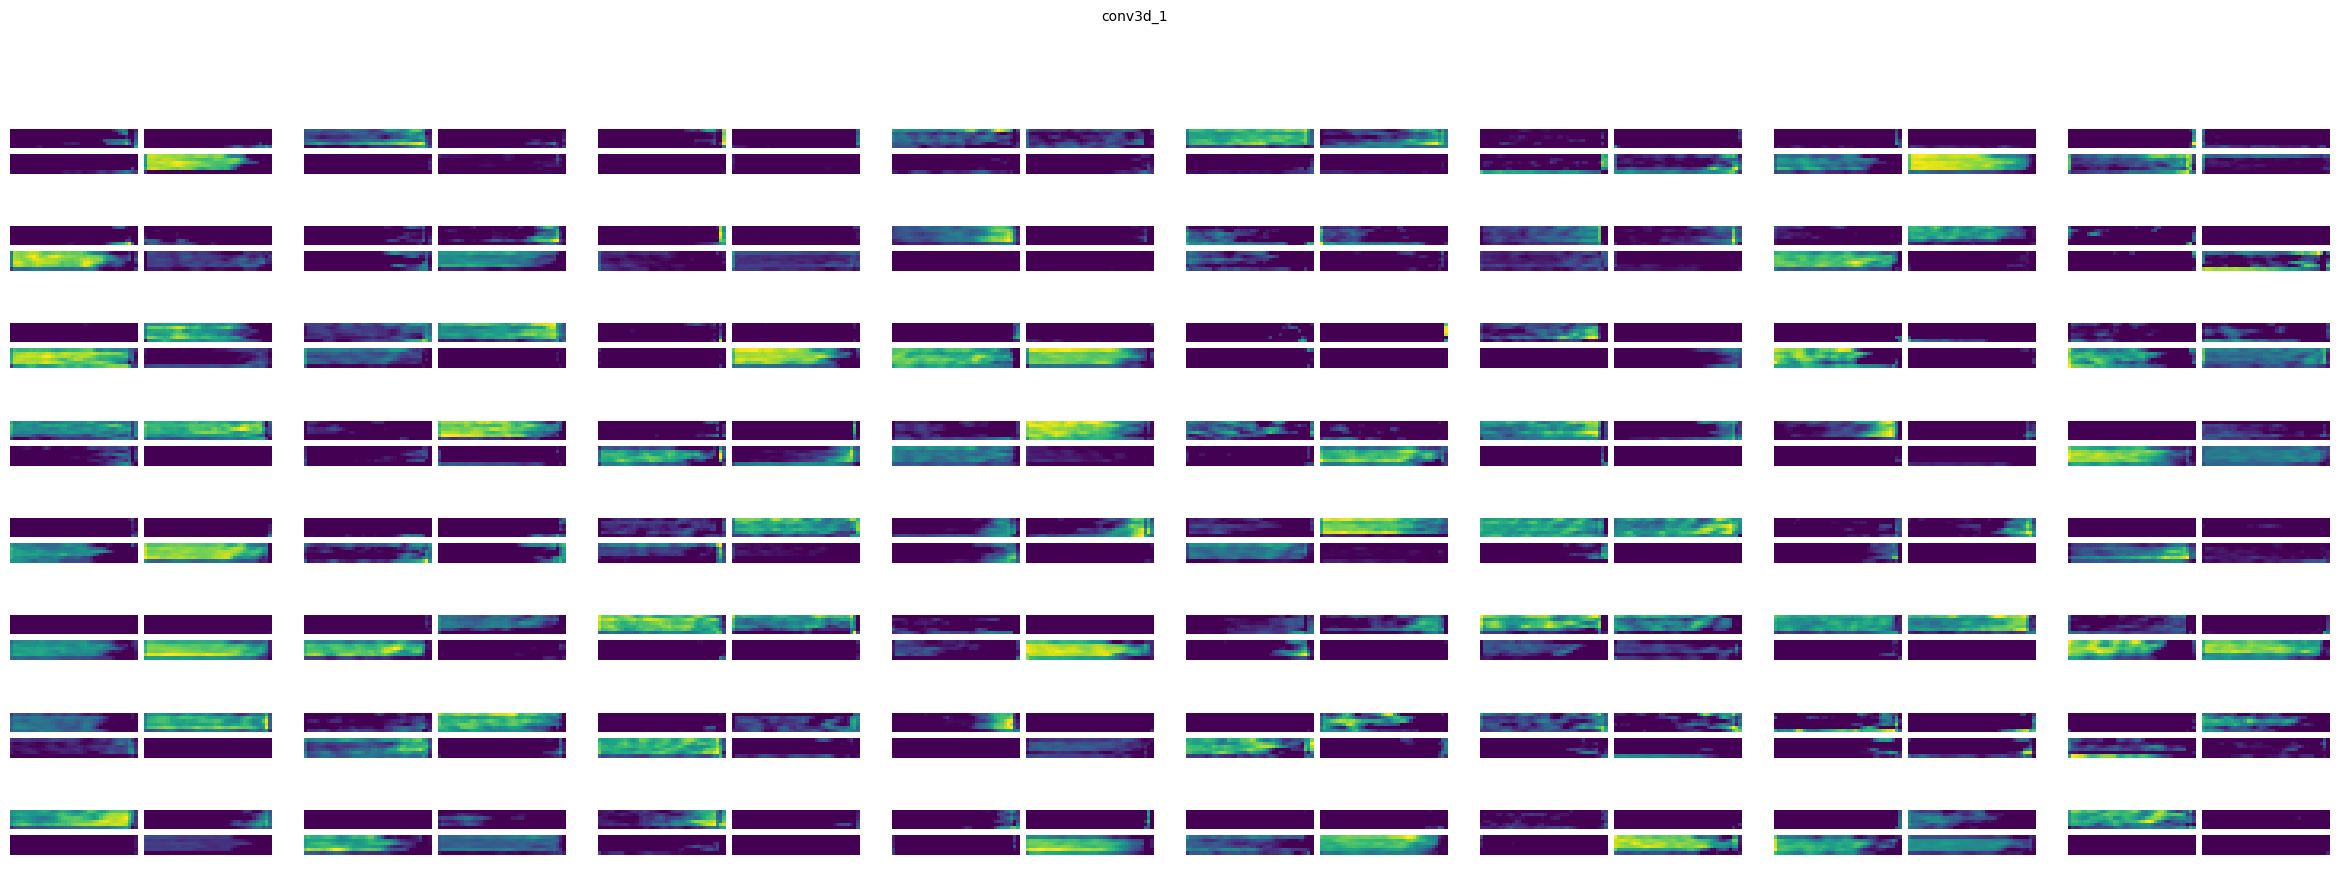

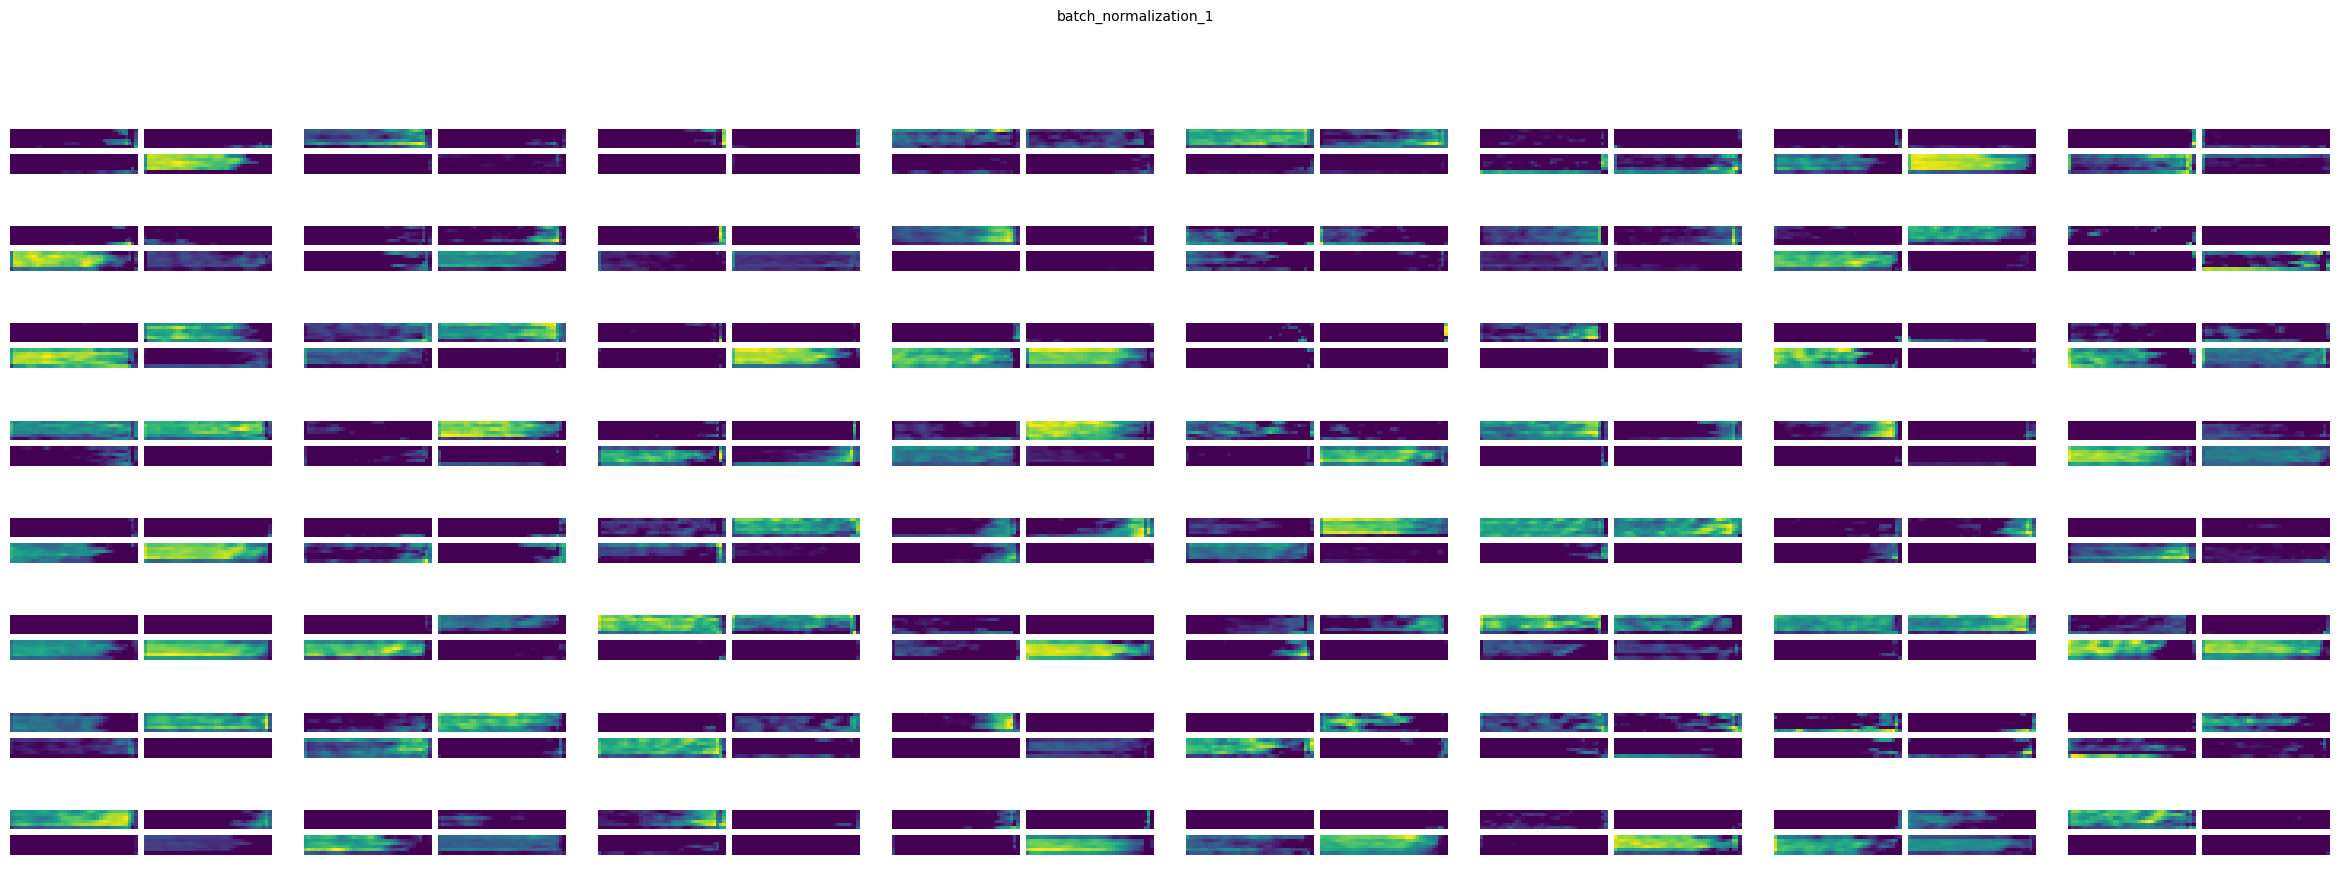

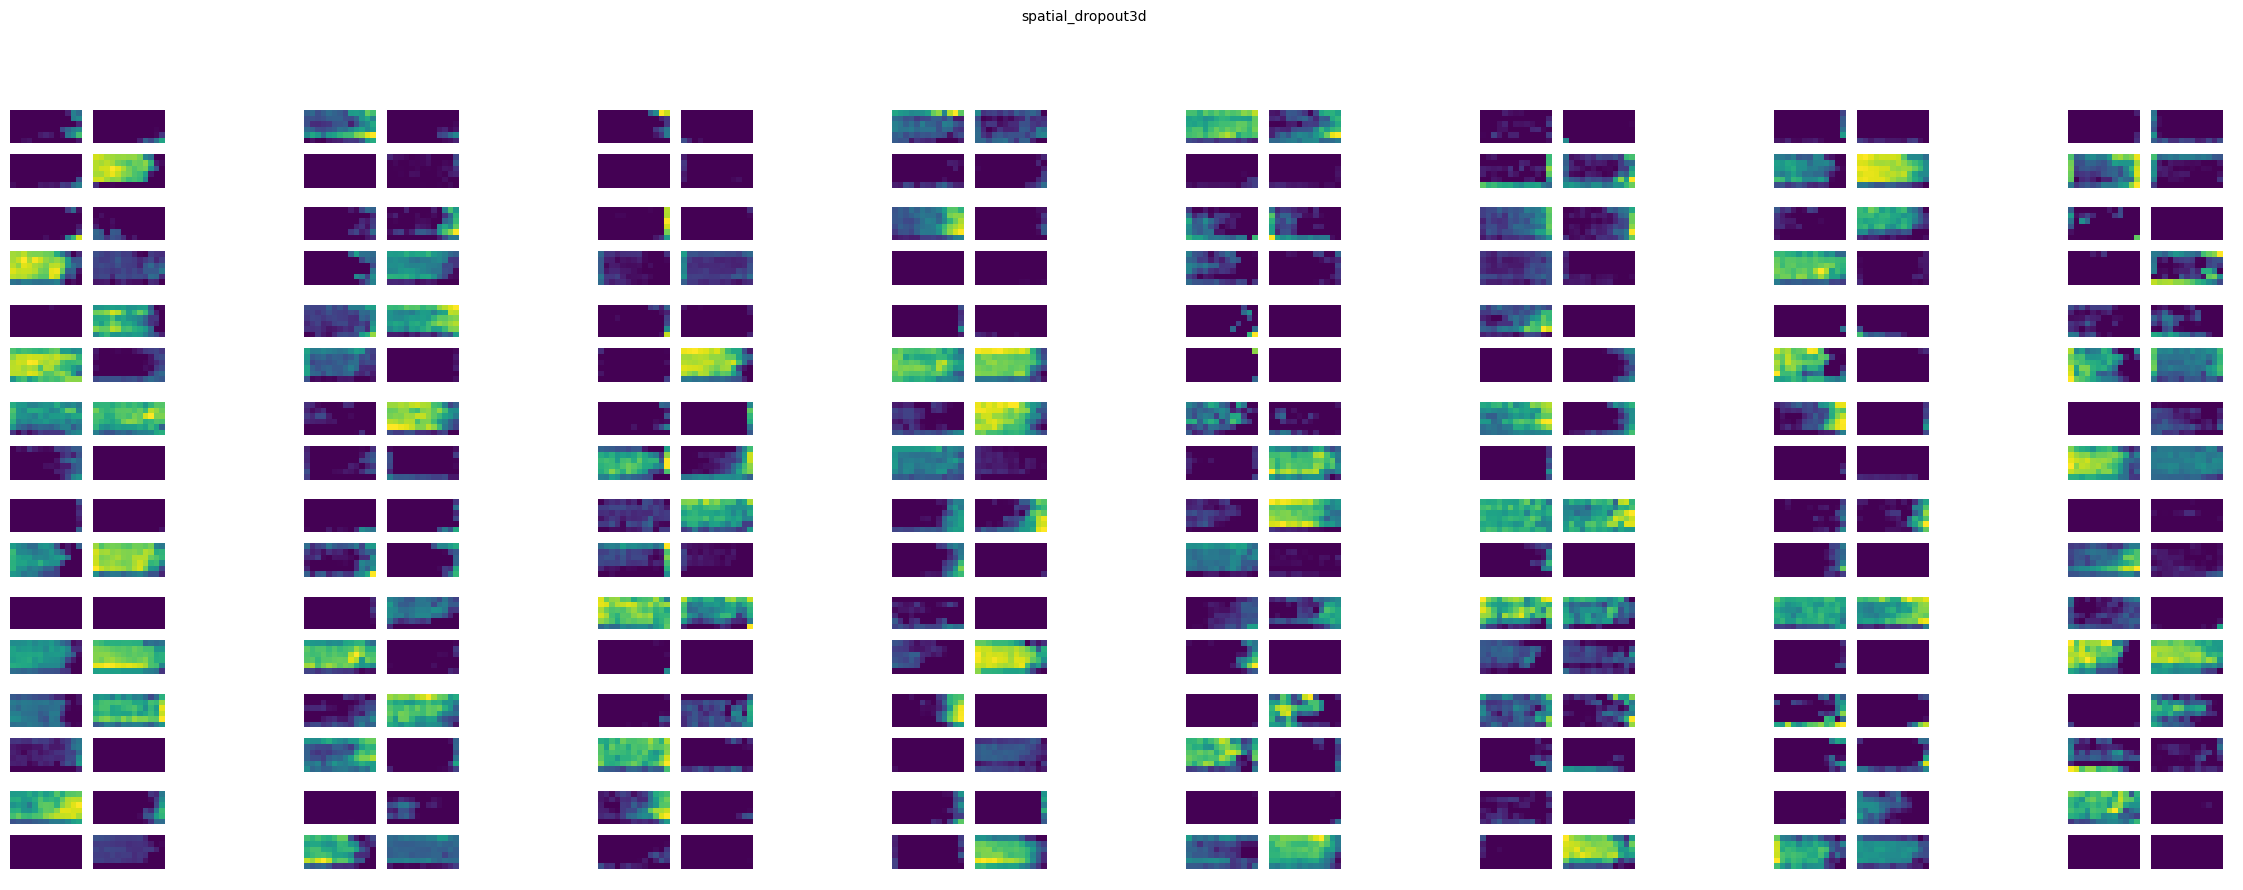

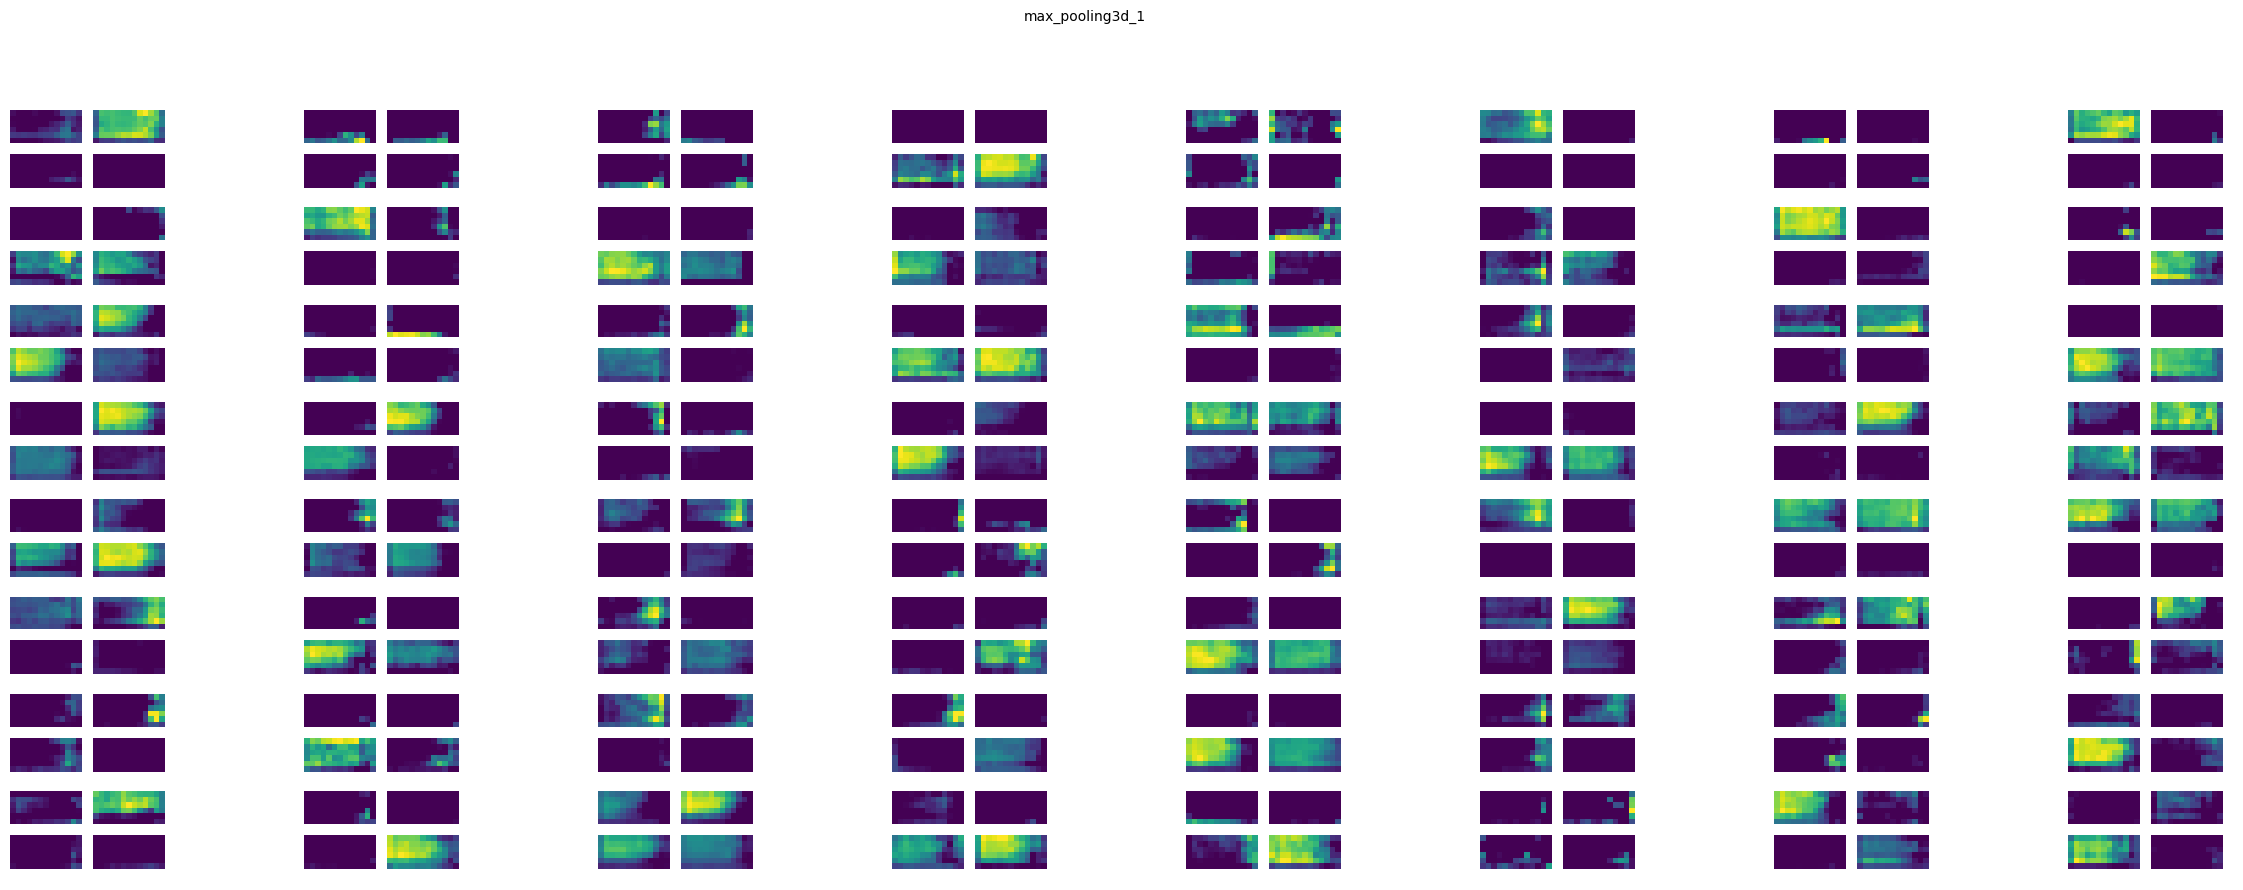

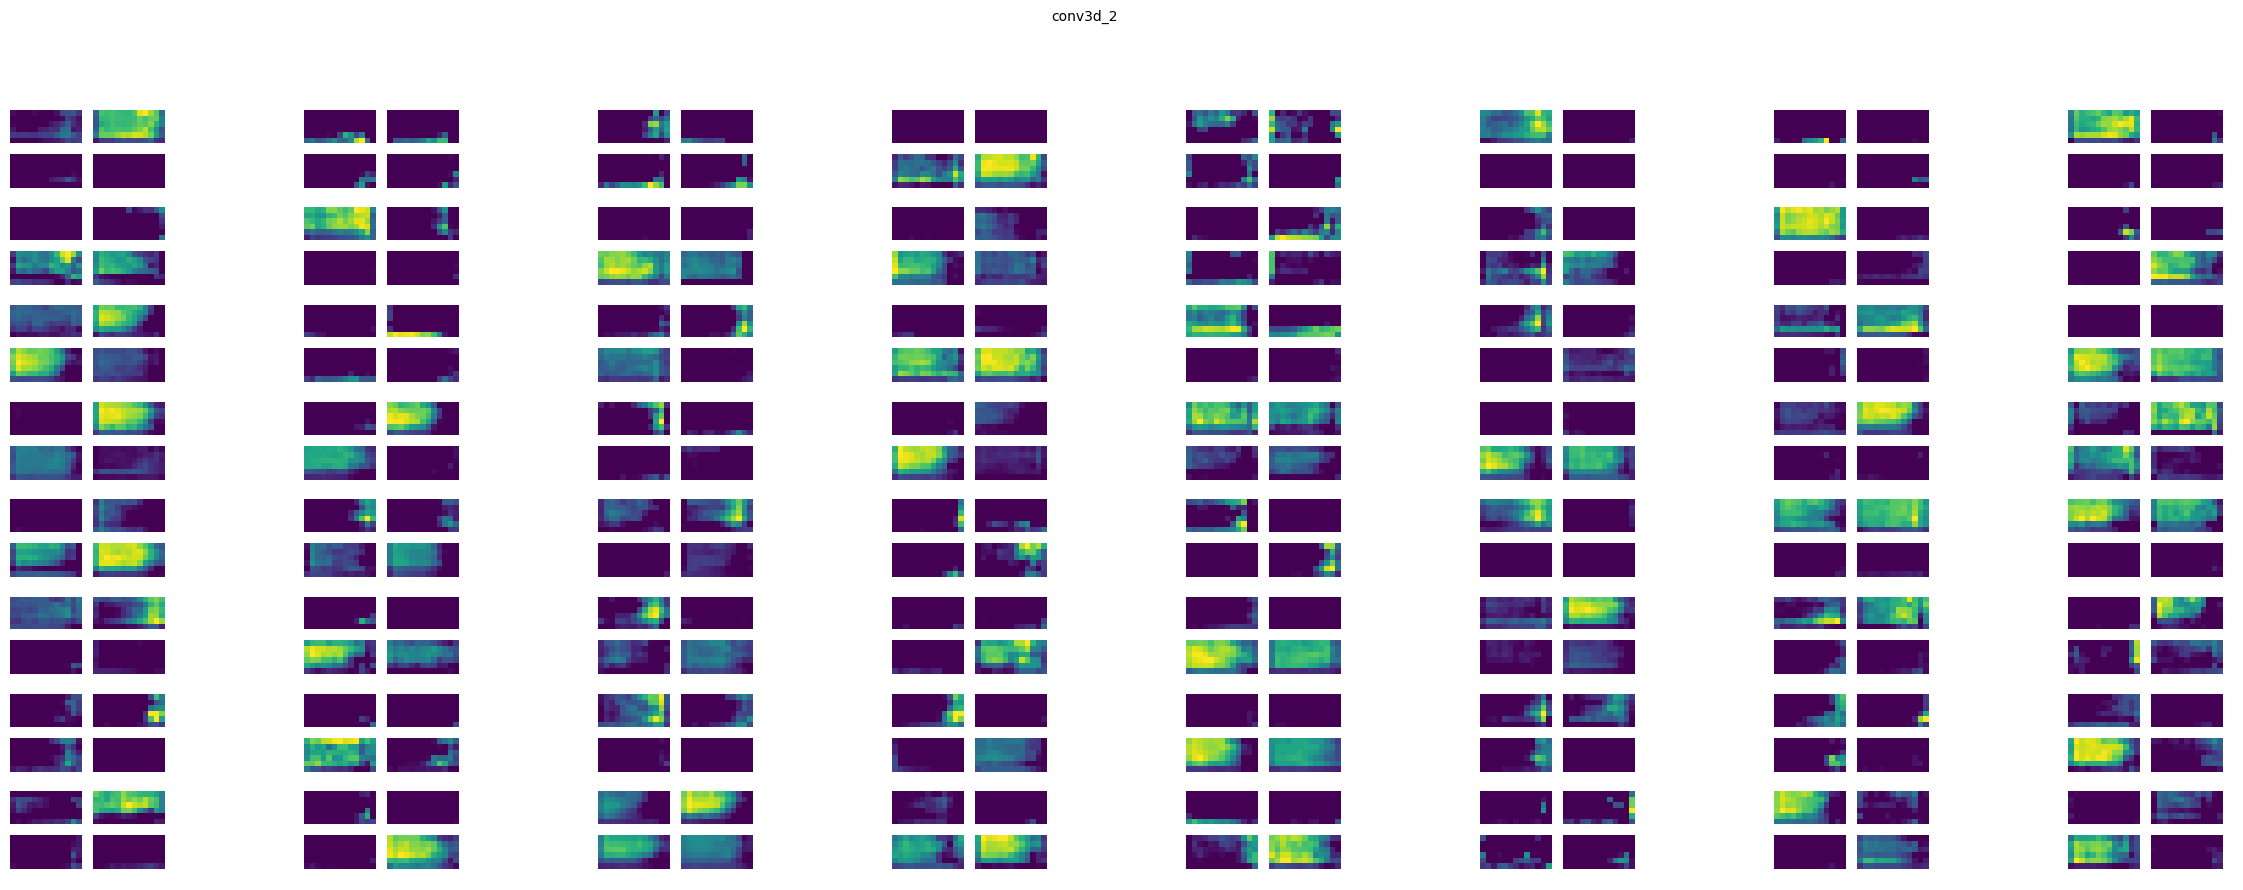

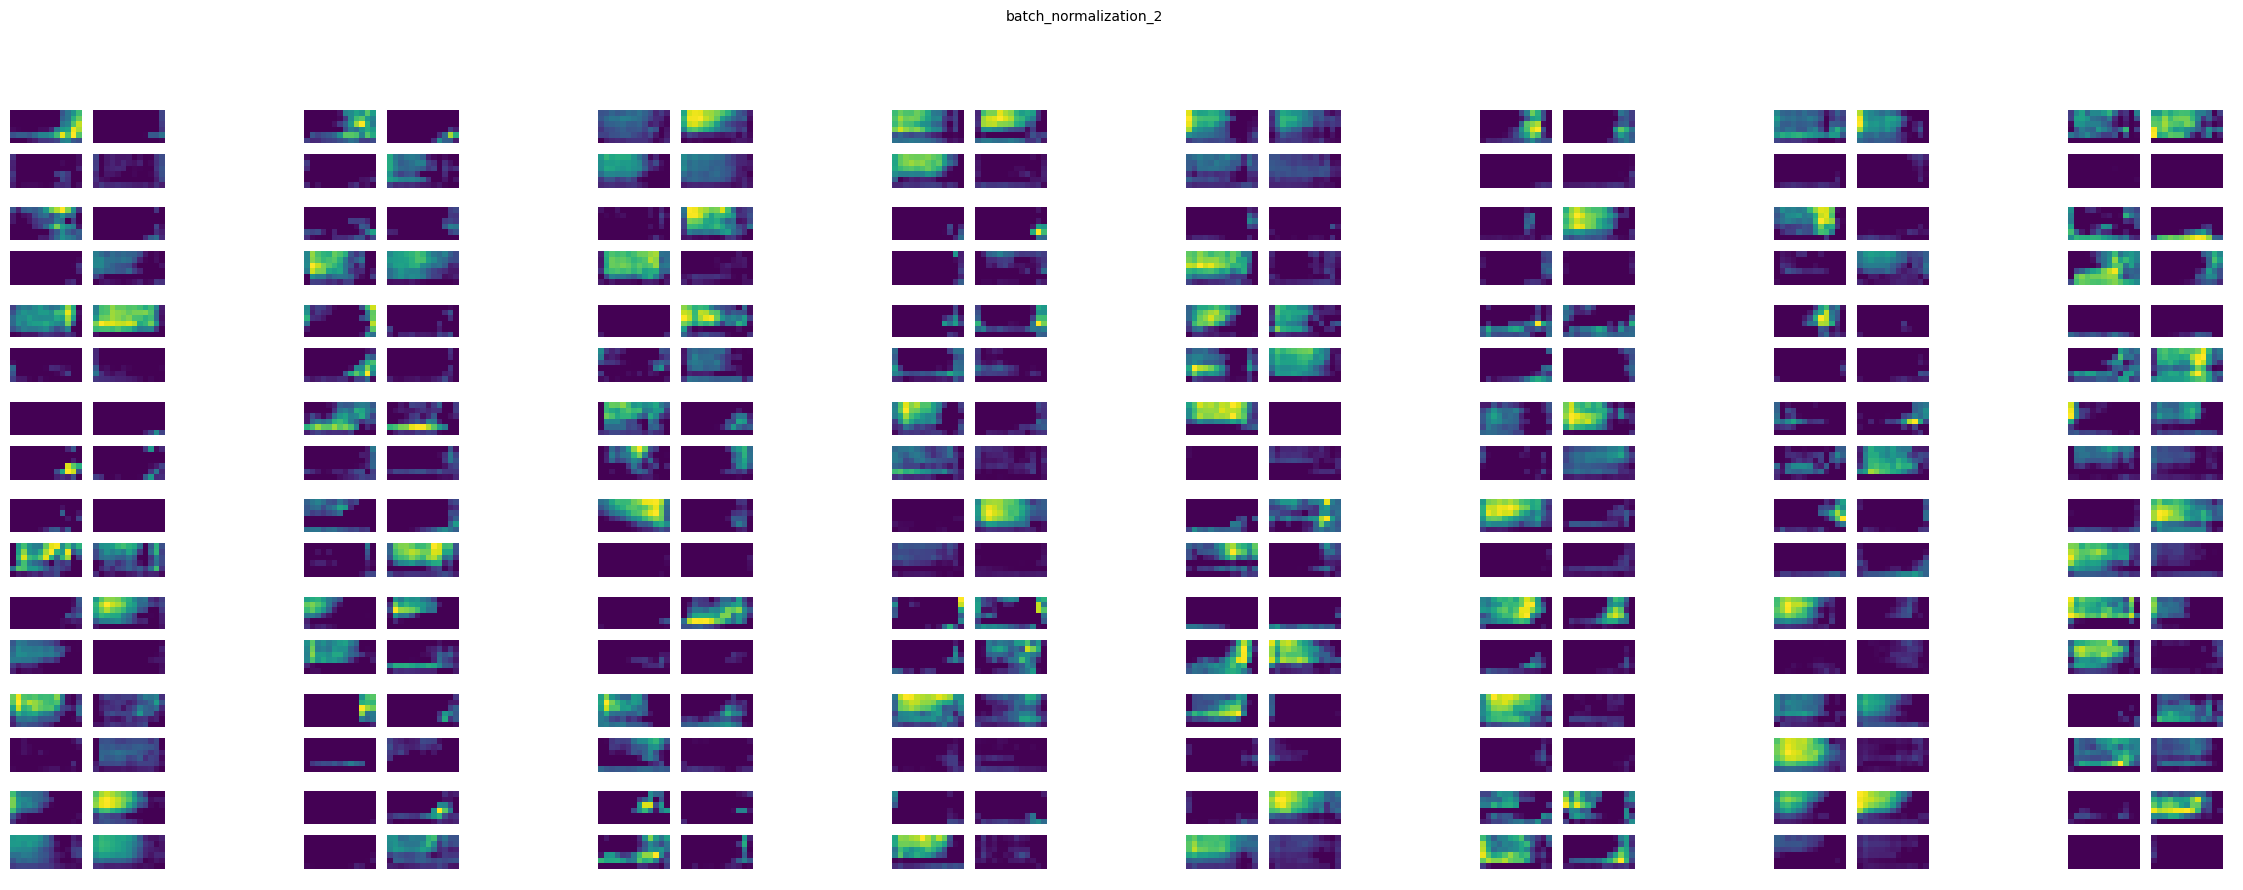

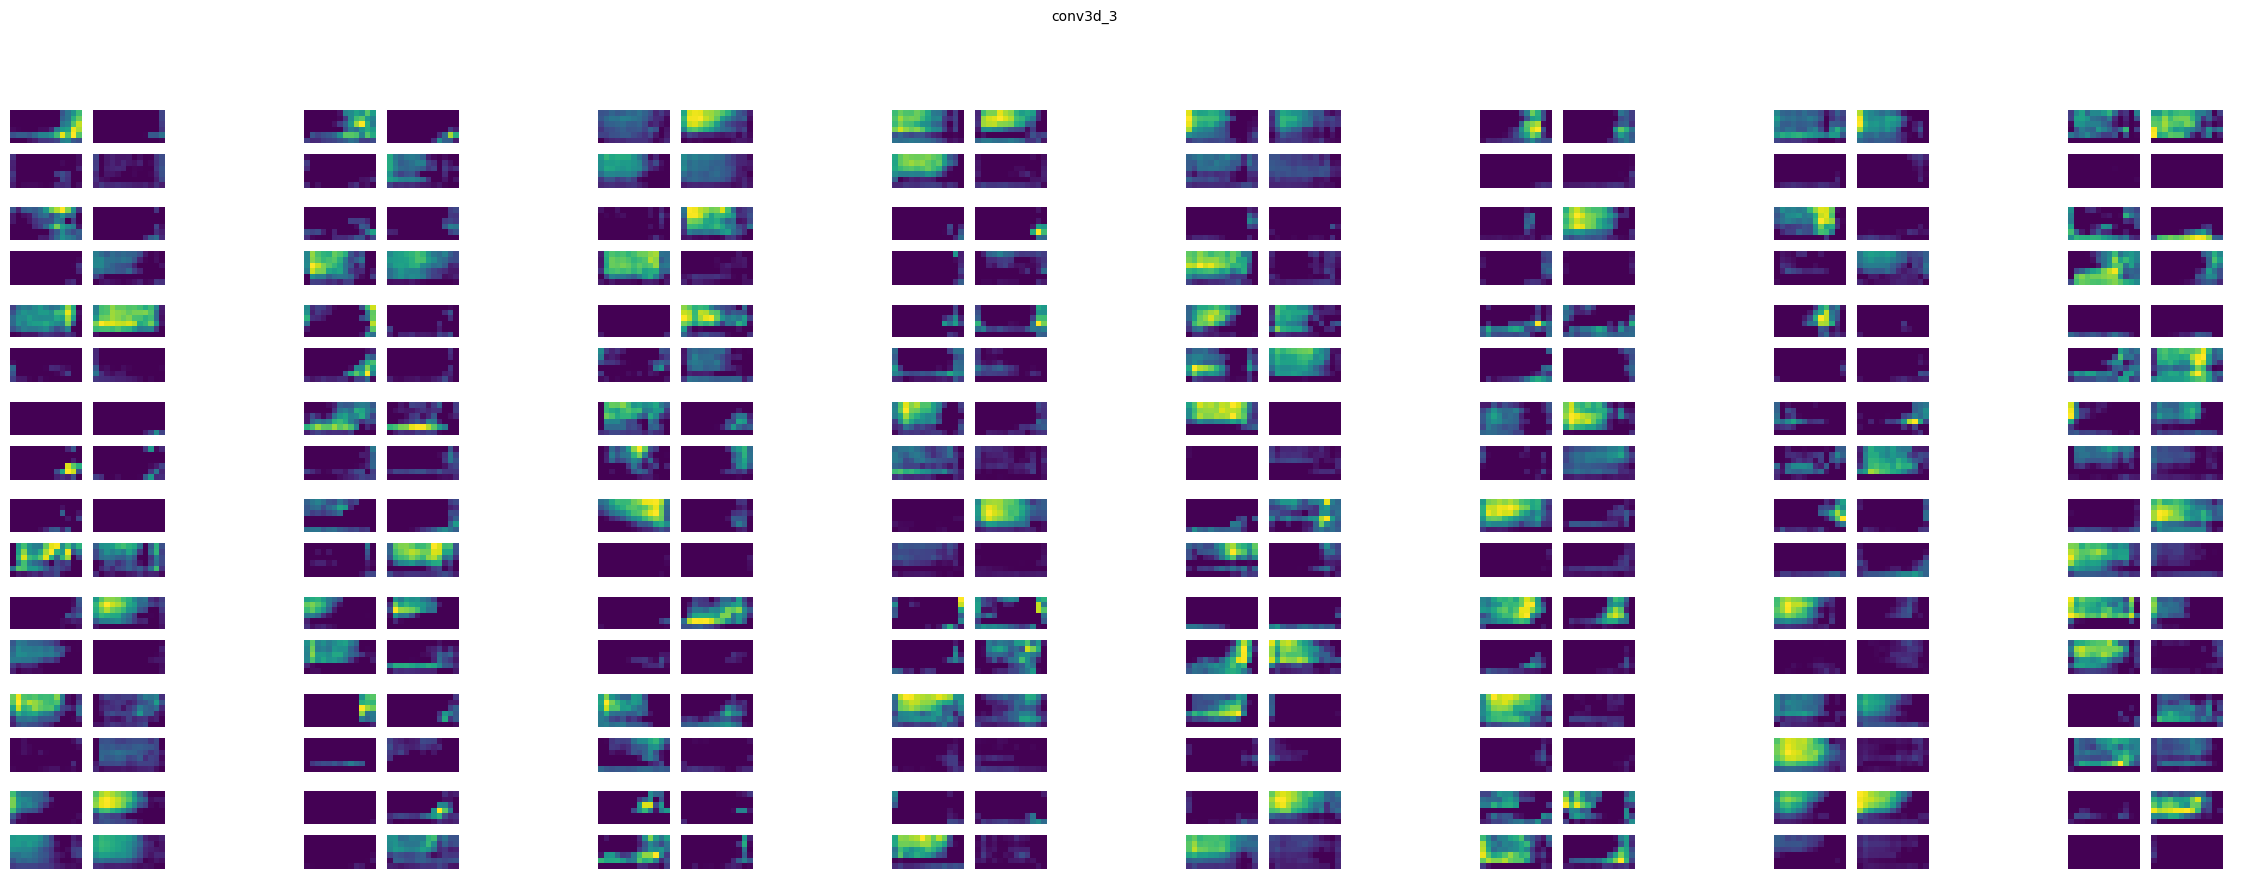

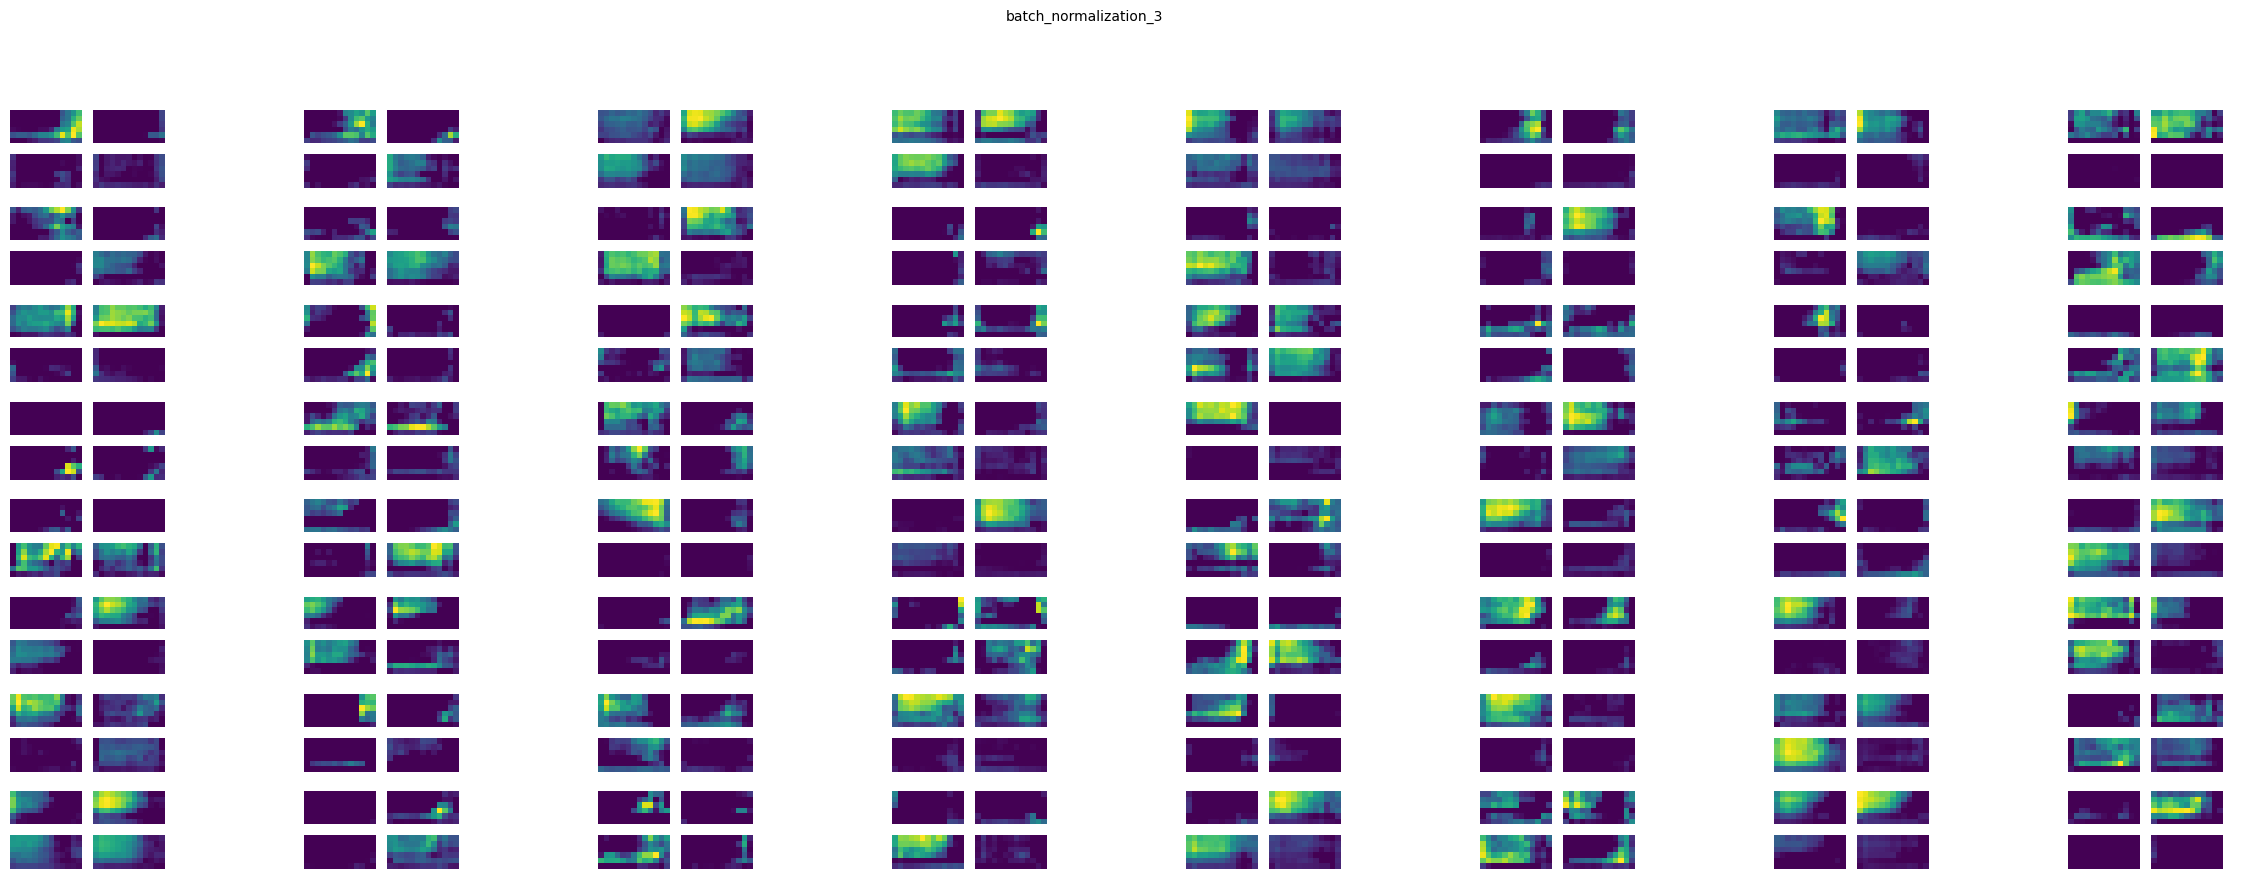

In [85]:
padding = 2

# Iterate through the layers and feature maps
for layerName, featureMap in zip(layerNames, featureMaps):
    if len(featureMap.shape) == 5:
        numFilters = min(featureMap.shape[-1], 64)
        numRows = 8  # Number of rows for sub-squares
        numCols = 8  # Number of columns for sub-squares

        fig = plt.figure(figsize=(30, 10))

        for i in range(numFilters):
            ax = fig.add_subplot(numRows, numCols, i + 1)

            # Stack the frames from the feature map
            stackedImage = featureMap[0, :, :, :, i]

            # Calculate the dimensions for sub-squares with padding
            subSquareSize = (
                stackedImage.shape[1] + padding,
                stackedImage.shape[2] + padding,
            )

            # Create a canvas for arranging the sub-squares
            canvas = np.ones((2 * subSquareSize[0], 2 * subSquareSize[1])) * np.nan

            # Place each frame in a sub-square with padding
            for j in range(stackedImage.shape[0]):
                row = j // 2
                col = j % 2
                frame = stackedImage[j, :, :]
                canvas[
                    row * subSquareSize[0] : (row + 1) * subSquareSize[0] - padding,
                    col * subSquareSize[1] : (col + 1) * subSquareSize[1] - padding,
                ] = frame

            ax.imshow(canvas, cmap="viridis")
            # ax.set_title(f"Filter {i + 1}")
            ax.axis("off")

        plt.subplots_adjust(
            wspace=0.1, hspace=0.1
        )  # Adjust spacing between sub-squares
        fig.suptitle(layerName, fontsize=10)
        plt.show()

#### Model Interpretation Using GRAD-CAM (slightly modified for regression)


In [86]:
def regressionActivationMap(img, model, lastConvLayerName, targetValue):
    gradModel = tf.keras.models.Model(
        [model.inputs], [model.get_layer(lastConvLayerName).output, model.output]
    )

    # compute the predicted value using the model
    with tf.GradientTape() as tape:
        lastConvOutput, pred = gradModel(img)

        # modify the loss function for regression (MSE loss)
        loss = tf.keras.losses.mean_squared_error(targetValue, pred)

    # compute gradients of the loss with respect to the activations of the last conv layer
    grads = tape.gradient(loss, lastConvOutput)

    # compute the weight of each feature map (global average pooling)
    grads = tf.abs(grads)
    pooledGrads = tf.reduce_mean(grads, axis=(0, 1, 2, 3))

    # compute a single heatmap by multiplying each feature map by its weight
    heatmap = lastConvOutput[0] @ pooledGrads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap


def resizeHeatmap(heatmap, shape):
    heatmap = scipy.ndimage.zoom(
        heatmap,
        (
            shape[0] / heatmap.shape[0],
            shape[1] / heatmap.shape[1],
            shape[2] / heatmap.shape[2],
        ),
    )

    return heatmap

In [ ]:
lastConvLayerName = "conv3d_3"
plotIndex = 20
heatmap = resizeHeatmap(
    regressionActivationMap(
        np.expand_dims(xValScaled[plotIndex], axis=0),
        model,
        lastConvLayerName,
        yVal[plotIndex],
    ),
    xValScaled[0].shape,
)

del lastConvLayerName

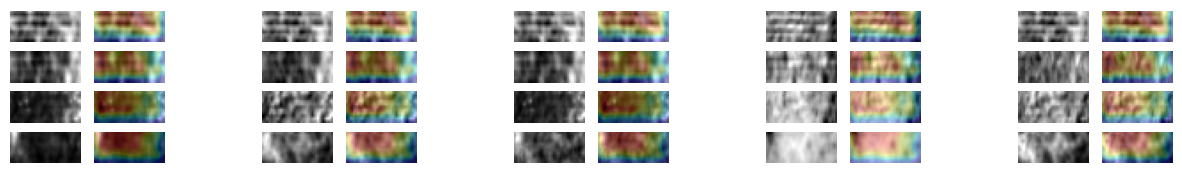

In [92]:
rows = xValScaled.shape[1]
cols = 2 * 5 + 4

row = 0
fig, ax = plt.subplots(rows, cols, figsize=(15, 2))
for timepoint in range(xValScaled.shape[1]):
    col = 0
    for channel in range(xVal.shape[-1]):
        ax[row, col].axis("off")

        if col in [2, 5, 8, 11]:
            # if (col + 1) % 3 == 0:
            col += 1

        ax[row, col].axis("off")
        ax[row, col + 1].axis("off")

        img0 = ax[row, col].imshow(
            xValScaled[plotIndex, timepoint, :, :, channel], cmap="gray"
        )
        ax[row, col + 1].imshow(
            xValScaled[plotIndex, timepoint, :, :, channel], cmap="gray"
        )
        img1 = ax[row, col + 1].imshow(
            heatmap[timepoint, :, :],
            cmap="jet",
            alpha=0.3,
            extent=img0.get_extent(),
        )

        col += 2

    row += 1

del img0, img1, rows, cols
plt.show()

#### Save Model


In [93]:
model.save("./Saved_Models/H2A4M1.keras")